In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import initializers

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import import_ipynb
from DataProcessing import Data
from xgboost_ipl import Xgboost


#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [51]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

X_train_observed_a = pd.read_parquet('dataset/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('dataset/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('dataset/C/X_train_observed.parquet')

X_train_estimated_a = pd.read_parquet('dataset/A/X_train_estimated.parquet') 
X_train_estimated_b = pd.read_parquet('dataset/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('dataset/C/X_train_estimated.parquet')

X_test_estimated_a = pd.read_parquet('dataset/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('dataset/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('dataset/C/X_test_estimated.parquet')

In [52]:
data = Data(train_a, train_b, train_c, X_train_observed_a, X_train_observed_b, X_train_observed_c,
                      X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_test_estimated_a, 
                      X_test_estimated_b, X_test_estimated_c)

In [ ]:
xg = Xgboost(data)

xg.model_a

In [55]:
def modelfit(alg, xs, ys, val_xs, val_ys, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xs, label=ys)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval =True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(xs, ys, eval_set=[(xs, ys),(val_xs, val_ys)], verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xs)
    dval_predictions = alg.predict(val_xs)
    
    mae = mean_absolute_error(dtrain_predictions, ys)
    mae_val = mean_absolute_error(dval_predictions, val_ys)
    print(mae, mae_val)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [56]:
import gc
gc.collect()

0

[0]	validation_0-mae:825.24660	validation_1-mae:751.58118
[1]	validation_0-mae:790.75866	validation_1-mae:719.81912
[2]	validation_0-mae:758.02962	validation_1-mae:690.09321
[3]	validation_0-mae:726.94172	validation_1-mae:662.16158
[4]	validation_0-mae:697.64823	validation_1-mae:635.77397
[5]	validation_0-mae:670.01537	validation_1-mae:610.96448
[6]	validation_0-mae:644.14641	validation_1-mae:587.21586
[7]	validation_0-mae:619.80807	validation_1-mae:565.27945
[8]	validation_0-mae:596.85079	validation_1-mae:544.45804
[9]	validation_0-mae:575.00121	validation_1-mae:524.89725
[10]	validation_0-mae:554.49660	validation_1-mae:505.92018
[11]	validation_0-mae:535.06345	validation_1-mae:488.68523
[12]	validation_0-mae:516.73513	validation_1-mae:472.04075
[13]	validation_0-mae:499.41308	validation_1-mae:456.63153
[14]	validation_0-mae:483.32449	validation_1-mae:442.14344
[15]	validation_0-mae:467.97185	validation_1-mae:428.78475
[16]	validation_0-mae:453.52526	validation_1-mae:415.92552
[17]	va

[139]	validation_0-mae:142.82669	validation_1-mae:161.93245
[140]	validation_0-mae:142.46783	validation_1-mae:161.84866
[141]	validation_0-mae:142.16748	validation_1-mae:161.74114
[142]	validation_0-mae:141.92452	validation_1-mae:161.68317
[143]	validation_0-mae:141.50635	validation_1-mae:161.63422
[144]	validation_0-mae:141.16083	validation_1-mae:161.55460
[145]	validation_0-mae:140.81148	validation_1-mae:161.55382
[146]	validation_0-mae:140.45676	validation_1-mae:161.58661
[147]	validation_0-mae:140.24513	validation_1-mae:161.56797
[148]	validation_0-mae:139.92252	validation_1-mae:161.57546
[149]	validation_0-mae:139.58270	validation_1-mae:161.51316
[150]	validation_0-mae:139.19259	validation_1-mae:161.47228
[151]	validation_0-mae:138.79837	validation_1-mae:161.43337
[152]	validation_0-mae:138.45917	validation_1-mae:161.37507
[153]	validation_0-mae:138.09855	validation_1-mae:161.25023
[154]	validation_0-mae:137.72847	validation_1-mae:161.20573
[155]	validation_0-mae:137.47975	validat

[276]	validation_0-mae:106.61150	validation_1-mae:159.25995
[277]	validation_0-mae:106.38346	validation_1-mae:159.24552
[278]	validation_0-mae:106.19314	validation_1-mae:159.24585
[279]	validation_0-mae:105.91985	validation_1-mae:159.22143
[280]	validation_0-mae:105.72759	validation_1-mae:159.23763
[281]	validation_0-mae:105.51576	validation_1-mae:159.29565
[282]	validation_0-mae:105.31737	validation_1-mae:159.30720
[283]	validation_0-mae:105.10282	validation_1-mae:159.33224
[284]	validation_0-mae:104.88382	validation_1-mae:159.33018
[285]	validation_0-mae:104.67382	validation_1-mae:159.32734
[286]	validation_0-mae:104.46666	validation_1-mae:159.32736
[287]	validation_0-mae:104.24858	validation_1-mae:159.34999
[288]	validation_0-mae:104.02350	validation_1-mae:159.36331
[289]	validation_0-mae:103.79286	validation_1-mae:159.34812
[290]	validation_0-mae:103.59172	validation_1-mae:159.33308
[291]	validation_0-mae:103.39756	validation_1-mae:159.30954
[292]	validation_0-mae:103.22613	validat

[415]	validation_0-mae:82.81084	validation_1-mae:159.29963
[416]	validation_0-mae:82.64522	validation_1-mae:159.34501
[417]	validation_0-mae:82.52868	validation_1-mae:159.36728
[418]	validation_0-mae:82.38286	validation_1-mae:159.40419
[419]	validation_0-mae:82.26141	validation_1-mae:159.42488
[420]	validation_0-mae:82.09617	validation_1-mae:159.39597
[421]	validation_0-mae:81.94901	validation_1-mae:159.41137
[422]	validation_0-mae:81.79580	validation_1-mae:159.41899
[423]	validation_0-mae:81.66525	validation_1-mae:159.39382
[424]	validation_0-mae:81.51976	validation_1-mae:159.39238
[425]	validation_0-mae:81.42120	validation_1-mae:159.39813
[426]	validation_0-mae:81.26434	validation_1-mae:159.40540
[427]	validation_0-mae:81.12854	validation_1-mae:159.40709
[428]	validation_0-mae:80.99444	validation_1-mae:159.43771
[429]	validation_0-mae:80.83800	validation_1-mae:159.40693
[430]	validation_0-mae:80.67892	validation_1-mae:159.41595
[431]	validation_0-mae:80.53534	validation_1-mae:159.450

[554]	validation_0-mae:66.11283	validation_1-mae:159.38048
[555]	validation_0-mae:66.00016	validation_1-mae:159.39763
[556]	validation_0-mae:65.89115	validation_1-mae:159.39766
[557]	validation_0-mae:65.80505	validation_1-mae:159.40273
[558]	validation_0-mae:65.72157	validation_1-mae:159.40146
[559]	validation_0-mae:65.58483	validation_1-mae:159.40707
[560]	validation_0-mae:65.47869	validation_1-mae:159.38606
[561]	validation_0-mae:65.36672	validation_1-mae:159.42388
[562]	validation_0-mae:65.26959	validation_1-mae:159.42629
[563]	validation_0-mae:65.15518	validation_1-mae:159.41292
[564]	validation_0-mae:65.04057	validation_1-mae:159.42374
[565]	validation_0-mae:64.93483	validation_1-mae:159.43471
[566]	validation_0-mae:64.82493	validation_1-mae:159.45612
[567]	validation_0-mae:64.72150	validation_1-mae:159.44586
[568]	validation_0-mae:64.64870	validation_1-mae:159.44554
[569]	validation_0-mae:64.53353	validation_1-mae:159.43453
[570]	validation_0-mae:64.44879	validation_1-mae:159.452

[693]	validation_0-mae:53.49486	validation_1-mae:159.46203
[694]	validation_0-mae:53.40230	validation_1-mae:159.44786
[695]	validation_0-mae:53.30996	validation_1-mae:159.46550
[696]	validation_0-mae:53.21793	validation_1-mae:159.47301
[697]	validation_0-mae:53.12695	validation_1-mae:159.46035
[698]	validation_0-mae:53.02527	validation_1-mae:159.46134
[699]	validation_0-mae:52.94772	validation_1-mae:159.47908
[700]	validation_0-mae:52.87132	validation_1-mae:159.50184
[701]	validation_0-mae:52.80196	validation_1-mae:159.48704
[702]	validation_0-mae:52.74497	validation_1-mae:159.49726
[703]	validation_0-mae:52.65087	validation_1-mae:159.50459
[704]	validation_0-mae:52.56199	validation_1-mae:159.52179
[705]	validation_0-mae:52.48490	validation_1-mae:159.52709
[706]	validation_0-mae:52.40787	validation_1-mae:159.52527
[707]	validation_0-mae:52.31586	validation_1-mae:159.50863
[708]	validation_0-mae:52.23229	validation_1-mae:159.51050
[709]	validation_0-mae:52.14592	validation_1-mae:159.530

[832]	validation_0-mae:43.74304	validation_1-mae:159.76688
[833]	validation_0-mae:43.70272	validation_1-mae:159.76126
[834]	validation_0-mae:43.65112	validation_1-mae:159.79941
[835]	validation_0-mae:43.59352	validation_1-mae:159.79970
[836]	validation_0-mae:43.53655	validation_1-mae:159.80073
[837]	validation_0-mae:43.46609	validation_1-mae:159.77888
[838]	validation_0-mae:43.41178	validation_1-mae:159.79598
[839]	validation_0-mae:43.34011	validation_1-mae:159.79415
[840]	validation_0-mae:43.27759	validation_1-mae:159.78768
[841]	validation_0-mae:43.23087	validation_1-mae:159.77219
[842]	validation_0-mae:43.16914	validation_1-mae:159.77864
[843]	validation_0-mae:43.10020	validation_1-mae:159.78671
[844]	validation_0-mae:43.04128	validation_1-mae:159.77850
[845]	validation_0-mae:42.99056	validation_1-mae:159.77319
[846]	validation_0-mae:42.93287	validation_1-mae:159.77066
[847]	validation_0-mae:42.88060	validation_1-mae:159.76762
[848]	validation_0-mae:42.82255	validation_1-mae:159.778

[971]	validation_0-mae:36.07540	validation_1-mae:160.04774
[972]	validation_0-mae:36.03309	validation_1-mae:160.04374
[973]	validation_0-mae:35.99724	validation_1-mae:160.04830
[974]	validation_0-mae:35.94931	validation_1-mae:160.04672
[975]	validation_0-mae:35.89724	validation_1-mae:160.06288
[976]	validation_0-mae:35.83948	validation_1-mae:160.06765
[977]	validation_0-mae:35.78718	validation_1-mae:160.07798
[978]	validation_0-mae:35.73846	validation_1-mae:160.07061
[979]	validation_0-mae:35.69401	validation_1-mae:160.07792
[980]	validation_0-mae:35.64038	validation_1-mae:160.07360
[981]	validation_0-mae:35.59963	validation_1-mae:160.08140
[982]	validation_0-mae:35.55403	validation_1-mae:160.08320
[983]	validation_0-mae:35.51394	validation_1-mae:160.08995
[984]	validation_0-mae:35.47046	validation_1-mae:160.09299
[985]	validation_0-mae:35.42669	validation_1-mae:160.07792
[986]	validation_0-mae:35.39340	validation_1-mae:160.07876
[987]	validation_0-mae:35.34139	validation_1-mae:160.086

[1109]	validation_0-mae:30.01733	validation_1-mae:160.13082
[1110]	validation_0-mae:29.97366	validation_1-mae:160.13323
[1111]	validation_0-mae:29.93271	validation_1-mae:160.12134
[1112]	validation_0-mae:29.89159	validation_1-mae:160.12422
[1113]	validation_0-mae:29.85583	validation_1-mae:160.12893
[1114]	validation_0-mae:29.81818	validation_1-mae:160.13064
[1115]	validation_0-mae:29.79050	validation_1-mae:160.12902
[1116]	validation_0-mae:29.76129	validation_1-mae:160.14038
[1117]	validation_0-mae:29.71666	validation_1-mae:160.12378
[1118]	validation_0-mae:29.67585	validation_1-mae:160.11753
[1119]	validation_0-mae:29.64229	validation_1-mae:160.11711
[1120]	validation_0-mae:29.60494	validation_1-mae:160.12347
[1121]	validation_0-mae:29.56622	validation_1-mae:160.11762
[1122]	validation_0-mae:29.53814	validation_1-mae:160.11811
[1123]	validation_0-mae:29.51091	validation_1-mae:160.11395
[1124]	validation_0-mae:29.48298	validation_1-mae:160.11852
[1125]	validation_0-mae:29.44555	validat

[1246]	validation_0-mae:25.21595	validation_1-mae:160.27787
[1247]	validation_0-mae:25.17781	validation_1-mae:160.27147
[1248]	validation_0-mae:25.14899	validation_1-mae:160.29076
[1249]	validation_0-mae:25.11307	validation_1-mae:160.29643
[1250]	validation_0-mae:25.07413	validation_1-mae:160.29733
[1251]	validation_0-mae:25.04406	validation_1-mae:160.30154
[1252]	validation_0-mae:25.01084	validation_1-mae:160.30671
[1253]	validation_0-mae:24.98583	validation_1-mae:160.31037
[1254]	validation_0-mae:24.94432	validation_1-mae:160.31541
[1255]	validation_0-mae:24.91356	validation_1-mae:160.29929
[1256]	validation_0-mae:24.88815	validation_1-mae:160.29625
[1257]	validation_0-mae:24.86388	validation_1-mae:160.29478
[1258]	validation_0-mae:24.83635	validation_1-mae:160.29908
[1259]	validation_0-mae:24.80016	validation_1-mae:160.30491
[1260]	validation_0-mae:24.77530	validation_1-mae:160.30291
[1261]	validation_0-mae:24.74638	validation_1-mae:160.30532
[1262]	validation_0-mae:24.71764	validat

[1519]	validation_0-mae:18.07621	validation_1-mae:160.54153
[1520]	validation_0-mae:18.05682	validation_1-mae:160.54207
[1521]	validation_0-mae:18.03467	validation_1-mae:160.53887
[1522]	validation_0-mae:18.01314	validation_1-mae:160.53747
[1523]	validation_0-mae:17.99138	validation_1-mae:160.54159
[1524]	validation_0-mae:17.97142	validation_1-mae:160.54769
[1525]	validation_0-mae:17.95148	validation_1-mae:160.54794
[1526]	validation_0-mae:17.93585	validation_1-mae:160.54702
[1527]	validation_0-mae:17.91456	validation_1-mae:160.54533
[1528]	validation_0-mae:17.89071	validation_1-mae:160.55356
[1529]	validation_0-mae:17.87090	validation_1-mae:160.55213
[1530]	validation_0-mae:17.84938	validation_1-mae:160.55755
[1531]	validation_0-mae:17.82683	validation_1-mae:160.55331
[1532]	validation_0-mae:17.80643	validation_1-mae:160.56139
[1533]	validation_0-mae:17.78496	validation_1-mae:160.56048
[1534]	validation_0-mae:17.76234	validation_1-mae:160.56444
[1535]	validation_0-mae:17.74231	validat

[1656]	validation_0-mae:15.43454	validation_1-mae:160.65021
[1657]	validation_0-mae:15.42091	validation_1-mae:160.65123
[1658]	validation_0-mae:15.40597	validation_1-mae:160.65249
[1659]	validation_0-mae:15.38756	validation_1-mae:160.65831
[1660]	validation_0-mae:15.37029	validation_1-mae:160.64927
[1661]	validation_0-mae:15.35174	validation_1-mae:160.65192
[1662]	validation_0-mae:15.33130	validation_1-mae:160.65024
[1663]	validation_0-mae:15.31248	validation_1-mae:160.65300
[1664]	validation_0-mae:15.29492	validation_1-mae:160.65500
[1665]	validation_0-mae:15.27823	validation_1-mae:160.65707
[1666]	validation_0-mae:15.25716	validation_1-mae:160.65866
[1667]	validation_0-mae:15.23858	validation_1-mae:160.66160
[1668]	validation_0-mae:15.22426	validation_1-mae:160.66037
[1669]	validation_0-mae:15.20752	validation_1-mae:160.65711
[1670]	validation_0-mae:15.19173	validation_1-mae:160.66405
[1671]	validation_0-mae:15.17230	validation_1-mae:160.66748
[1672]	validation_0-mae:15.15401	validat

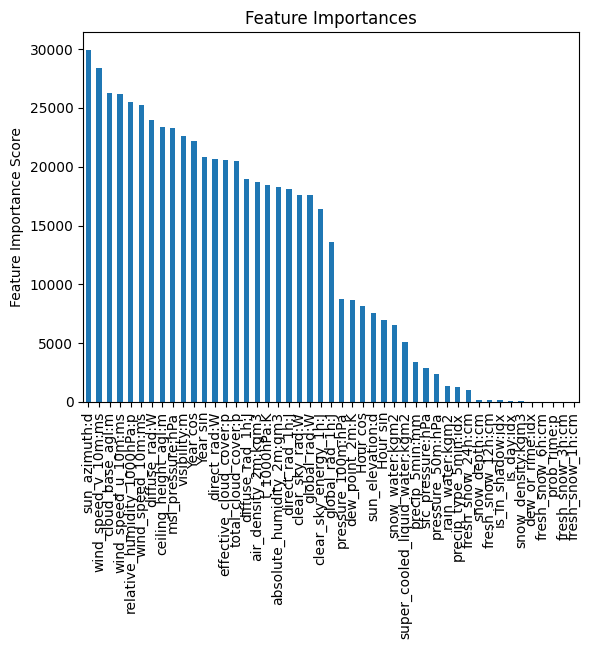

In [58]:
model_a = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=1693,
 max_depth=16,
 min_child_weight=9,
 gamma=4.709926652039647,
 subsample=0.5746022561573897,
 colsample_bytree=0.925119931399705,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha=77.7952642777926,
 reg_lambda=102.6220459955603,
)

modelfit(model_a, data.A.train_x, data.A.train_y, data.A.val_x, data.A.val_y, useTrainCV = False)

[0]	train-mae:147.75517+0.44760	test-mae:147.78970+1.53342
[1]	train-mae:141.76995+0.39533	test-mae:141.84722+1.50611
[2]	train-mae:136.06897+0.35392	test-mae:136.18509+1.50497
[3]	train-mae:130.65803+0.31448	test-mae:130.81437+1.49993
[4]	train-mae:125.54823+0.28809	test-mae:125.73631+1.48268
[5]	train-mae:120.69934+0.24537	test-mae:120.92613+1.48701
[6]	train-mae:116.09074+0.24759	test-mae:116.35435+1.47744
[7]	train-mae:111.72956+0.23558	test-mae:112.02470+1.48346
[8]	train-mae:107.64361+0.21175	test-mae:107.99993+1.47689
[9]	train-mae:103.74714+0.20009	test-mae:104.15572+1.46878
[10]	train-mae:100.04732+0.20648	test-mae:100.47701+1.43487
[11]	train-mae:96.55831+0.19288	test-mae:97.03915+1.42621
[12]	train-mae:93.23762+0.17685	test-mae:93.75021+1.39091
[13]	train-mae:90.10180+0.17041	test-mae:90.64914+1.35247
[14]	train-mae:87.13841+0.19883	test-mae:87.71488+1.30229
[15]	train-mae:84.32896+0.19149	test-mae:84.95486+1.28690
[16]	train-mae:81.65169+0.17302	test-mae:82.32984+1.26439
[1

[141]	train-mae:25.86191+0.23919	test-mae:31.18035+0.80503
[142]	train-mae:25.81937+0.23556	test-mae:31.16971+0.81160
[143]	train-mae:25.76995+0.23790	test-mae:31.14767+0.80426
[144]	train-mae:25.72248+0.23453	test-mae:31.12707+0.81101
[145]	train-mae:25.67777+0.22982	test-mae:31.10595+0.82150
[146]	train-mae:25.63794+0.23687	test-mae:31.09253+0.82307
[147]	train-mae:25.59224+0.23301	test-mae:31.07613+0.82999
[148]	train-mae:25.54487+0.23248	test-mae:31.05816+0.83070
[149]	train-mae:25.50729+0.23253	test-mae:31.04372+0.82663
[150]	train-mae:25.46679+0.22788	test-mae:31.02883+0.83128
[151]	train-mae:25.42224+0.22536	test-mae:31.01464+0.83252
[152]	train-mae:25.37450+0.22137	test-mae:30.99359+0.83735
[153]	train-mae:25.32958+0.22733	test-mae:30.98004+0.83586
[154]	train-mae:25.28881+0.22767	test-mae:30.96599+0.83593
[155]	train-mae:25.25013+0.22155	test-mae:30.95449+0.84332
[156]	train-mae:25.20220+0.22473	test-mae:30.93911+0.84213
[157]	train-mae:25.16218+0.22794	test-mae:30.92622+0.846

[280]	train-mae:20.93088+0.14998	test-mae:29.77686+1.01442
[281]	train-mae:20.89987+0.15567	test-mae:29.76639+1.00926
[282]	train-mae:20.87423+0.15458	test-mae:29.76545+1.01109
[283]	train-mae:20.84423+0.15400	test-mae:29.75962+1.01517
[284]	train-mae:20.81550+0.14949	test-mae:29.75208+1.01749
[285]	train-mae:20.78876+0.14337	test-mae:29.74811+1.02247
[286]	train-mae:20.75736+0.14552	test-mae:29.73637+1.01821
[287]	train-mae:20.73146+0.14542	test-mae:29.73530+1.01600
[288]	train-mae:20.71067+0.15032	test-mae:29.73233+1.01381
[289]	train-mae:20.68909+0.15052	test-mae:29.72944+1.01019
[290]	train-mae:20.66029+0.14711	test-mae:29.71822+1.01111
[291]	train-mae:20.63562+0.15106	test-mae:29.71543+1.01092
[292]	train-mae:20.61215+0.15229	test-mae:29.71040+1.01253
[293]	train-mae:20.58462+0.15557	test-mae:29.70545+1.01242
[294]	train-mae:20.55847+0.15286	test-mae:29.69958+1.01490
[295]	train-mae:20.53492+0.15288	test-mae:29.69794+1.01713
[296]	train-mae:20.50622+0.15524	test-mae:29.68968+1.016

[419]	train-mae:17.62998+0.13804	test-mae:29.18328+1.06681
[420]	train-mae:17.60626+0.13550	test-mae:29.17782+1.06694
[421]	train-mae:17.58735+0.13435	test-mae:29.17421+1.07041
[422]	train-mae:17.56525+0.13107	test-mae:29.17169+1.07175
[423]	train-mae:17.54747+0.13031	test-mae:29.17166+1.06984
[424]	train-mae:17.53040+0.12680	test-mae:29.17328+1.07050
[425]	train-mae:17.50925+0.12514	test-mae:29.16920+1.07287
[426]	train-mae:17.49134+0.12739	test-mae:29.16671+1.07054
[427]	train-mae:17.47388+0.12710	test-mae:29.16461+1.06964
[428]	train-mae:17.45613+0.13007	test-mae:29.16536+1.06982
[429]	train-mae:17.43651+0.12865	test-mae:29.16061+1.07333
[430]	train-mae:17.41603+0.13065	test-mae:29.15573+1.06909
[431]	train-mae:17.39624+0.12488	test-mae:29.14750+1.06921
[432]	train-mae:17.37557+0.12276	test-mae:29.14309+1.07264
[433]	train-mae:17.35616+0.12407	test-mae:29.13814+1.06985
[434]	train-mae:17.33558+0.12969	test-mae:29.13620+1.06846
[435]	train-mae:17.31586+0.13066	test-mae:29.13523+1.069

[558]	train-mae:15.13374+0.09122	test-mae:28.79062+1.06973
[559]	train-mae:15.11731+0.09155	test-mae:28.79197+1.07029
[560]	train-mae:15.10258+0.09044	test-mae:28.79311+1.07095
[561]	train-mae:15.08715+0.09289	test-mae:28.79058+1.06771
[562]	train-mae:15.07230+0.09635	test-mae:28.79165+1.06577
[563]	train-mae:15.05812+0.09244	test-mae:28.79242+1.06874
[564]	train-mae:15.04025+0.08879	test-mae:28.79104+1.06951
[565]	train-mae:15.02353+0.08795	test-mae:28.78973+1.06973
[566]	train-mae:15.00430+0.08494	test-mae:28.78597+1.07165
[567]	train-mae:14.98725+0.08624	test-mae:28.78260+1.07126
[568]	train-mae:14.97133+0.08356	test-mae:28.78193+1.07276
[569]	train-mae:14.95699+0.08159	test-mae:28.77967+1.07451
[570]	train-mae:14.94551+0.07893	test-mae:28.78074+1.07604
[571]	train-mae:14.93050+0.08099	test-mae:28.77845+1.07578
[572]	train-mae:14.91579+0.08316	test-mae:28.77781+1.07627
[573]	train-mae:14.89970+0.08406	test-mae:28.77343+1.07504
[574]	train-mae:14.88354+0.08067	test-mae:28.76897+1.075

[697]	train-mae:13.16500+0.06298	test-mae:28.56657+1.09773
[698]	train-mae:13.14848+0.06276	test-mae:28.56323+1.09824
[699]	train-mae:13.13780+0.06468	test-mae:28.56196+1.09702
[700]	train-mae:13.12869+0.06370	test-mae:28.56286+1.09624
[701]	train-mae:13.11408+0.06132	test-mae:28.55941+1.09885
[702]	train-mae:13.10053+0.06257	test-mae:28.55744+1.09589
[703]	train-mae:13.08715+0.06420	test-mae:28.55534+1.09555
[704]	train-mae:13.07459+0.06324	test-mae:28.55655+1.09439
[705]	train-mae:13.05982+0.06063	test-mae:28.55375+1.09492
[706]	train-mae:13.04897+0.06135	test-mae:28.55152+1.09448
[707]	train-mae:13.03677+0.06121	test-mae:28.55016+1.09324
[708]	train-mae:13.02700+0.06078	test-mae:28.54957+1.09473
[709]	train-mae:13.01694+0.06237	test-mae:28.54846+1.09688
[710]	train-mae:13.00236+0.06192	test-mae:28.54696+1.09528
[711]	train-mae:12.99014+0.06399	test-mae:28.54660+1.09424
[712]	train-mae:12.97586+0.06827	test-mae:28.54095+1.09196
[713]	train-mae:12.96244+0.07005	test-mae:28.54079+1.090

[836]	train-mae:11.54051+0.05781	test-mae:28.34212+1.08049
[837]	train-mae:11.52997+0.05867	test-mae:28.34130+1.08083
[838]	train-mae:11.51834+0.05839	test-mae:28.34059+1.08084
[839]	train-mae:11.50768+0.05972	test-mae:28.34010+1.08029
[840]	train-mae:11.49636+0.05790	test-mae:28.34113+1.08111
[841]	train-mae:11.48628+0.05548	test-mae:28.34025+1.08210
[842]	train-mae:11.47595+0.05525	test-mae:28.33841+1.08127
[843]	train-mae:11.46669+0.05590	test-mae:28.33698+1.08247
[844]	train-mae:11.45612+0.05281	test-mae:28.33828+1.08473
[845]	train-mae:11.44714+0.05277	test-mae:28.33943+1.08490
[846]	train-mae:11.43685+0.05256	test-mae:28.33940+1.08435
[847]	train-mae:11.42775+0.05311	test-mae:28.33897+1.08401
[848]	train-mae:11.41649+0.05272	test-mae:28.33745+1.08376
[849]	train-mae:11.40701+0.05291	test-mae:28.33715+1.08232
[850]	train-mae:11.39547+0.05392	test-mae:28.33539+1.08182
[851]	train-mae:11.38194+0.05469	test-mae:28.33304+1.08109
[852]	train-mae:11.37090+0.05492	test-mae:28.33269+1.079

[975]	train-mae:10.19209+0.03821	test-mae:28.18356+1.08713
[976]	train-mae:10.18256+0.03942	test-mae:28.18114+1.08722
[977]	train-mae:10.17433+0.04041	test-mae:28.18001+1.08447
[978]	train-mae:10.16344+0.04215	test-mae:28.17967+1.08364
[979]	train-mae:10.15461+0.04161	test-mae:28.17923+1.08231
[980]	train-mae:10.14550+0.04039	test-mae:28.17817+1.08319
[981]	train-mae:10.13596+0.04094	test-mae:28.17815+1.08265
[982]	train-mae:10.12877+0.04002	test-mae:28.17731+1.08250
[983]	train-mae:10.12004+0.04091	test-mae:28.17694+1.08197
[984]	train-mae:10.11021+0.04064	test-mae:28.17799+1.08100
[985]	train-mae:10.10224+0.04029	test-mae:28.17693+1.08262
[986]	train-mae:10.09296+0.03958	test-mae:28.17571+1.08465
[987]	train-mae:10.08431+0.03977	test-mae:28.17486+1.08451
[988]	train-mae:10.07732+0.03750	test-mae:28.17598+1.08660
[989]	train-mae:10.06780+0.03797	test-mae:28.17429+1.08723
[990]	train-mae:10.05946+0.03868	test-mae:28.17294+1.08740
[991]	train-mae:10.04970+0.03915	test-mae:28.17104+1.087

[1114]	train-mae:9.05738+0.04226	test-mae:28.04441+1.06919
[1115]	train-mae:9.05015+0.04096	test-mae:28.04373+1.06890
[1116]	train-mae:9.04260+0.04157	test-mae:28.04159+1.06884
[1117]	train-mae:9.03510+0.04189	test-mae:28.04163+1.06934
[1118]	train-mae:9.02641+0.04252	test-mae:28.03870+1.06828
[1119]	train-mae:9.02031+0.04240	test-mae:28.03722+1.06739
[1120]	train-mae:9.01284+0.04247	test-mae:28.03769+1.06664
[1121]	train-mae:9.00551+0.04403	test-mae:28.03679+1.06521
[1122]	train-mae:8.99801+0.04536	test-mae:28.03520+1.06574
[1123]	train-mae:8.98981+0.04569	test-mae:28.03430+1.06495
[1124]	train-mae:8.98171+0.04568	test-mae:28.03273+1.06615
[1125]	train-mae:8.97453+0.04625	test-mae:28.03174+1.06596
[1126]	train-mae:8.96732+0.04699	test-mae:28.03164+1.06666
[1127]	train-mae:8.95836+0.04771	test-mae:28.03101+1.06675
[1128]	train-mae:8.95201+0.04835	test-mae:28.03072+1.06767
[1129]	train-mae:8.94371+0.04975	test-mae:28.02684+1.06611
[1130]	train-mae:8.93623+0.04779	test-mae:28.02574+1.066

[1253]	train-mae:8.08766+0.05178	test-mae:27.91878+1.04024
[1254]	train-mae:8.08219+0.05224	test-mae:27.91835+1.04044
[1255]	train-mae:8.07465+0.05227	test-mae:27.91705+1.04199
[1256]	train-mae:8.06773+0.05198	test-mae:27.91557+1.04167
[1257]	train-mae:8.06249+0.05148	test-mae:27.91407+1.04071
[1258]	train-mae:8.05602+0.05085	test-mae:27.91291+1.04047
[1259]	train-mae:8.04864+0.05204	test-mae:27.91168+1.03942
[1260]	train-mae:8.04149+0.05187	test-mae:27.90976+1.03963
[1261]	train-mae:8.03447+0.05069	test-mae:27.90806+1.03916
[1262]	train-mae:8.02849+0.04948	test-mae:27.90867+1.04067
[1263]	train-mae:8.02170+0.05022	test-mae:27.90910+1.03996
[1264]	train-mae:8.01596+0.05114	test-mae:27.90881+1.04042
[1265]	train-mae:8.00944+0.05072	test-mae:27.90858+1.04078
[1266]	train-mae:8.00383+0.05085	test-mae:27.90874+1.03878
[1267]	train-mae:7.99905+0.04983	test-mae:27.90784+1.03905
[1268]	train-mae:7.99232+0.05028	test-mae:27.90611+1.03854
[1269]	train-mae:7.98702+0.05002	test-mae:27.90663+1.038

[1392]	train-mae:7.25506+0.04507	test-mae:27.81039+1.03415
[1393]	train-mae:7.24992+0.04493	test-mae:27.81036+1.03434
[1394]	train-mae:7.24391+0.04490	test-mae:27.80965+1.03311
[1395]	train-mae:7.23700+0.04608	test-mae:27.80822+1.03248
[1396]	train-mae:7.23200+0.04701	test-mae:27.80776+1.03170
[1397]	train-mae:7.22691+0.04755	test-mae:27.80652+1.03159
[1398]	train-mae:7.22156+0.04818	test-mae:27.80529+1.03231
[1399]	train-mae:7.21699+0.04905	test-mae:27.80480+1.03224
[1400]	train-mae:7.21130+0.04880	test-mae:27.80221+1.03259
[1401]	train-mae:7.20654+0.04827	test-mae:27.80124+1.03272
[1402]	train-mae:7.20157+0.04987	test-mae:27.80123+1.03265
[1403]	train-mae:7.19632+0.05039	test-mae:27.80092+1.03329
[1404]	train-mae:7.19165+0.05017	test-mae:27.80083+1.03303
[1405]	train-mae:7.18539+0.05111	test-mae:27.79954+1.03311
[1406]	train-mae:7.18051+0.05180	test-mae:27.79762+1.03504
[1407]	train-mae:7.17600+0.05108	test-mae:27.79801+1.03505
[1408]	train-mae:7.17189+0.05065	test-mae:27.79925+1.033

[1531]	train-mae:6.55486+0.05004	test-mae:27.71175+1.02611
[1532]	train-mae:6.55000+0.04999	test-mae:27.71099+1.02634
[1533]	train-mae:6.54485+0.04927	test-mae:27.71032+1.02625
[1534]	train-mae:6.54003+0.04826	test-mae:27.71017+1.02681
[1535]	train-mae:6.53586+0.04740	test-mae:27.71026+1.02573
[1536]	train-mae:6.53092+0.04717	test-mae:27.70858+1.02580
[1537]	train-mae:6.52675+0.04773	test-mae:27.70813+1.02545
[1538]	train-mae:6.52237+0.04772	test-mae:27.70731+1.02491
[1539]	train-mae:6.51848+0.04738	test-mae:27.70741+1.02469
[1540]	train-mae:6.51294+0.04766	test-mae:27.70651+1.02448
[1541]	train-mae:6.50831+0.04727	test-mae:27.70561+1.02462
[1542]	train-mae:6.50388+0.04687	test-mae:27.70568+1.02405
[1543]	train-mae:6.49909+0.04706	test-mae:27.70463+1.02467
[1544]	train-mae:6.49555+0.04800	test-mae:27.70362+1.02516
[1545]	train-mae:6.49060+0.04752	test-mae:27.70336+1.02600
[1546]	train-mae:6.48538+0.04735	test-mae:27.70219+1.02664
[1547]	train-mae:6.48089+0.04747	test-mae:27.70197+1.026

[1670]	train-mae:5.93635+0.04089	test-mae:27.63044+1.02326
[1671]	train-mae:5.93259+0.04112	test-mae:27.63013+1.02385
[1672]	train-mae:5.92804+0.04123	test-mae:27.62956+1.02399
[1673]	train-mae:5.92421+0.04110	test-mae:27.62930+1.02421
[1674]	train-mae:5.91952+0.04191	test-mae:27.62932+1.02462
[1675]	train-mae:5.91545+0.04154	test-mae:27.62760+1.02369
[1676]	train-mae:5.91084+0.04188	test-mae:27.62604+1.02351
[1677]	train-mae:5.90630+0.04136	test-mae:27.62426+1.02300
[1678]	train-mae:5.90236+0.04161	test-mae:27.62328+1.02343
[1679]	train-mae:5.89676+0.04203	test-mae:27.62256+1.02296
[1680]	train-mae:5.89307+0.04170	test-mae:27.62255+1.02257
[1681]	train-mae:5.88889+0.04144	test-mae:27.62266+1.02222
[1682]	train-mae:5.88571+0.04125	test-mae:27.62218+1.02146
[1683]	train-mae:5.88199+0.04083	test-mae:27.62196+1.02221
[1684]	train-mae:5.87833+0.04116	test-mae:27.62189+1.02132
[1685]	train-mae:5.87437+0.04089	test-mae:27.62164+1.02047
[1686]	train-mae:5.87005+0.04040	test-mae:27.62107+1.020

[1809]	train-mae:5.39378+0.03719	test-mae:27.56029+1.02466
[1810]	train-mae:5.38992+0.03734	test-mae:27.55901+1.02444
[1811]	train-mae:5.38577+0.03791	test-mae:27.55735+1.02476
[1812]	train-mae:5.38255+0.03818	test-mae:27.55689+1.02481
[1813]	train-mae:5.37839+0.03841	test-mae:27.55588+1.02433
[1814]	train-mae:5.37473+0.03854	test-mae:27.55493+1.02528
[1815]	train-mae:5.37169+0.03874	test-mae:27.55520+1.02515
[1816]	train-mae:5.36806+0.03835	test-mae:27.55422+1.02500
[1817]	train-mae:5.36454+0.03791	test-mae:27.55438+1.02525
[1818]	train-mae:5.36163+0.03777	test-mae:27.55457+1.02573
[1819]	train-mae:5.35873+0.03823	test-mae:27.55502+1.02507
[1820]	train-mae:5.35665+0.03818	test-mae:27.55471+1.02523
[1821]	train-mae:5.35335+0.03805	test-mae:27.55387+1.02546
[1822]	train-mae:5.34984+0.03802	test-mae:27.55378+1.02394
[1823]	train-mae:5.34608+0.03790	test-mae:27.55351+1.02384
[1824]	train-mae:5.34292+0.03795	test-mae:27.55395+1.02410
[1825]	train-mae:5.33929+0.03784	test-mae:27.55378+1.024

[1948]	train-mae:4.92276+0.03699	test-mae:27.49596+1.01382
[1949]	train-mae:4.92017+0.03698	test-mae:27.49530+1.01366
[1950]	train-mae:4.91743+0.03694	test-mae:27.49515+1.01398
[1951]	train-mae:4.91459+0.03655	test-mae:27.49472+1.01358
[1952]	train-mae:4.91188+0.03686	test-mae:27.49386+1.01310
[1953]	train-mae:4.90867+0.03621	test-mae:27.49324+1.01322
[1954]	train-mae:4.90547+0.03613	test-mae:27.49263+1.01272
[1955]	train-mae:4.90161+0.03605	test-mae:27.49176+1.01336
[1956]	train-mae:4.89872+0.03583	test-mae:27.49222+1.01218
[1957]	train-mae:4.89500+0.03499	test-mae:27.49198+1.01165
[1958]	train-mae:4.89143+0.03479	test-mae:27.49190+1.01195
[1959]	train-mae:4.88845+0.03498	test-mae:27.49133+1.01167
[1960]	train-mae:4.88546+0.03487	test-mae:27.49172+1.01112
[1961]	train-mae:4.88244+0.03552	test-mae:27.49124+1.01067
[1962]	train-mae:4.87938+0.03582	test-mae:27.49121+1.01111
[1963]	train-mae:4.87556+0.03604	test-mae:27.49024+1.01087
[1964]	train-mae:4.87199+0.03614	test-mae:27.49009+1.011

[2087]	train-mae:4.51871+0.03533	test-mae:27.44821+1.01243
[2088]	train-mae:4.51567+0.03493	test-mae:27.44747+1.01292
[2089]	train-mae:4.51239+0.03532	test-mae:27.44672+1.01276
[2090]	train-mae:4.50938+0.03500	test-mae:27.44594+1.01255
[2091]	train-mae:4.50659+0.03478	test-mae:27.44497+1.01344
[2092]	train-mae:4.50451+0.03447	test-mae:27.44488+1.01352
[2093]	train-mae:4.50211+0.03446	test-mae:27.44472+1.01325
[2094]	train-mae:4.49978+0.03433	test-mae:27.44468+1.01336
[2095]	train-mae:4.49724+0.03435	test-mae:27.44467+1.01325
[2096]	train-mae:4.49427+0.03420	test-mae:27.44492+1.01369
[2097]	train-mae:4.49143+0.03480	test-mae:27.44495+1.01404
[2098]	train-mae:4.48847+0.03439	test-mae:27.44453+1.01468
[2099]	train-mae:4.48605+0.03450	test-mae:27.44470+1.01463
[2100]	train-mae:4.48334+0.03400	test-mae:27.44446+1.01484
[2101]	train-mae:4.48103+0.03441	test-mae:27.44374+1.01454
[2102]	train-mae:4.47799+0.03444	test-mae:27.44304+1.01478
[2103]	train-mae:4.47529+0.03453	test-mae:27.44273+1.014

[2226]	train-mae:4.15580+0.03191	test-mae:27.39228+1.01276
[2227]	train-mae:4.15329+0.03188	test-mae:27.39123+1.01221
[2228]	train-mae:4.15080+0.03184	test-mae:27.39098+1.01172
[2229]	train-mae:4.14838+0.03164	test-mae:27.39100+1.01124
[2230]	train-mae:4.14519+0.03173	test-mae:27.39036+1.01044
[2231]	train-mae:4.14311+0.03184	test-mae:27.39021+1.01073
[2232]	train-mae:4.14053+0.03209	test-mae:27.39024+1.01085
[2233]	train-mae:4.13793+0.03211	test-mae:27.38987+1.01139
[2234]	train-mae:4.13588+0.03211	test-mae:27.38984+1.01213
[2235]	train-mae:4.13320+0.03211	test-mae:27.39042+1.01184
[2236]	train-mae:4.13065+0.03228	test-mae:27.39082+1.01161
[2237]	train-mae:4.12830+0.03209	test-mae:27.39061+1.01200
[2238]	train-mae:4.12555+0.03240	test-mae:27.38973+1.01237
[2239]	train-mae:4.12339+0.03225	test-mae:27.38927+1.01271
[2240]	train-mae:4.12133+0.03222	test-mae:27.38945+1.01207
[2241]	train-mae:4.11909+0.03221	test-mae:27.38927+1.01216
[2242]	train-mae:4.11702+0.03226	test-mae:27.38851+1.011

[2365]	train-mae:3.83585+0.03335	test-mae:27.34908+1.01038
[2366]	train-mae:3.83364+0.03315	test-mae:27.34832+1.01064
[2367]	train-mae:3.83143+0.03323	test-mae:27.34750+1.01026
[2368]	train-mae:3.82924+0.03346	test-mae:27.34744+1.01019
[2369]	train-mae:3.82694+0.03354	test-mae:27.34706+1.00923
[2370]	train-mae:3.82506+0.03366	test-mae:27.34642+1.00920
[2371]	train-mae:3.82294+0.03397	test-mae:27.34626+1.00957
[2372]	train-mae:3.82070+0.03384	test-mae:27.34599+1.00989
[2373]	train-mae:3.81848+0.03393	test-mae:27.34645+1.00945
[2374]	train-mae:3.81614+0.03357	test-mae:27.34590+1.01006
[2375]	train-mae:3.81414+0.03315	test-mae:27.34666+1.01035
[2376]	train-mae:3.81197+0.03304	test-mae:27.34575+1.00981
[2377]	train-mae:3.81008+0.03292	test-mae:27.34542+1.00934
[2378]	train-mae:3.80757+0.03247	test-mae:27.34441+1.00993
[2379]	train-mae:3.80552+0.03261	test-mae:27.34461+1.00964
[2380]	train-mae:3.80364+0.03204	test-mae:27.34440+1.00933
[2381]	train-mae:3.80150+0.03179	test-mae:27.34343+1.009

[2504]	train-mae:3.55242+0.03160	test-mae:27.30305+1.00717
[2505]	train-mae:3.55077+0.03185	test-mae:27.30285+1.00658
[2506]	train-mae:3.54918+0.03164	test-mae:27.30299+1.00623
[2507]	train-mae:3.54716+0.03158	test-mae:27.30195+1.00615
[2508]	train-mae:3.54536+0.03155	test-mae:27.30163+1.00623
[2509]	train-mae:3.54355+0.03185	test-mae:27.30171+1.00635
[2510]	train-mae:3.54156+0.03192	test-mae:27.30138+1.00675
[2511]	train-mae:3.53983+0.03183	test-mae:27.30180+1.00702
[2512]	train-mae:3.53750+0.03194	test-mae:27.30092+1.00701
[2513]	train-mae:3.53550+0.03195	test-mae:27.30046+1.00614
[2514]	train-mae:3.53396+0.03220	test-mae:27.30035+1.00646
[2515]	train-mae:3.53209+0.03213	test-mae:27.30018+1.00640
[2516]	train-mae:3.52974+0.03219	test-mae:27.29966+1.00656
[2517]	train-mae:3.52789+0.03220	test-mae:27.29904+1.00660
[2518]	train-mae:3.52586+0.03232	test-mae:27.29901+1.00640
[2519]	train-mae:3.52397+0.03238	test-mae:27.29864+1.00654
[2520]	train-mae:3.52179+0.03273	test-mae:27.29890+1.006

[2643]	train-mae:3.30413+0.02801	test-mae:27.26764+1.00736
[2644]	train-mae:3.30261+0.02807	test-mae:27.26746+1.00740
[2645]	train-mae:3.30118+0.02814	test-mae:27.26760+1.00732
[2646]	train-mae:3.29949+0.02834	test-mae:27.26779+1.00776
[2647]	train-mae:3.29807+0.02857	test-mae:27.26807+1.00760
[2648]	train-mae:3.29637+0.02849	test-mae:27.26793+1.00791
[2649]	train-mae:3.29473+0.02854	test-mae:27.26796+1.00834
[2650]	train-mae:3.29294+0.02835	test-mae:27.26784+1.00851
[2651]	train-mae:3.29134+0.02851	test-mae:27.26752+1.00885
[2652]	train-mae:3.29020+0.02840	test-mae:27.26753+1.00899
[2653]	train-mae:3.28841+0.02833	test-mae:27.26782+1.00906
[2654]	train-mae:3.28642+0.02855	test-mae:27.26720+1.00905
[2655]	train-mae:3.28454+0.02880	test-mae:27.26631+1.00864
[2656]	train-mae:3.28277+0.02896	test-mae:27.26648+1.00852
[2657]	train-mae:3.28112+0.02865	test-mae:27.26610+1.00847
[2658]	train-mae:3.27932+0.02867	test-mae:27.26592+1.00839
[2659]	train-mae:3.27762+0.02877	test-mae:27.26561+1.008

[2782]	train-mae:3.08509+0.02654	test-mae:27.24281+1.00792
[2783]	train-mae:3.08356+0.02609	test-mae:27.24244+1.00776
[2784]	train-mae:3.08198+0.02616	test-mae:27.24196+1.00769
[2785]	train-mae:3.08062+0.02615	test-mae:27.24161+1.00739
[2786]	train-mae:3.07909+0.02611	test-mae:27.24179+1.00699
[2787]	train-mae:3.07761+0.02600	test-mae:27.24142+1.00680
[2788]	train-mae:3.07614+0.02645	test-mae:27.24111+1.00670
[2789]	train-mae:3.07480+0.02674	test-mae:27.24109+1.00644
[2790]	train-mae:3.07352+0.02648	test-mae:27.24066+1.00679
[2791]	train-mae:3.07186+0.02654	test-mae:27.24029+1.00671
[2792]	train-mae:3.07045+0.02681	test-mae:27.24030+1.00661
[2793]	train-mae:3.06918+0.02675	test-mae:27.23997+1.00688
[2794]	train-mae:3.06790+0.02673	test-mae:27.23965+1.00678
[2795]	train-mae:3.06646+0.02685	test-mae:27.23927+1.00693
[2796]	train-mae:3.06481+0.02677	test-mae:27.23860+1.00647
[2797]	train-mae:3.06334+0.02678	test-mae:27.23858+1.00657
[2798]	train-mae:3.06177+0.02675	test-mae:27.23842+1.006

[173]	validation_0-mae:24.33486	validation_1-mae:24.13717
[174]	validation_0-mae:24.29449	validation_1-mae:24.12958
[175]	validation_0-mae:24.25694	validation_1-mae:24.12705
[176]	validation_0-mae:24.21815	validation_1-mae:24.12779
[177]	validation_0-mae:24.19157	validation_1-mae:24.12966
[178]	validation_0-mae:24.15024	validation_1-mae:24.14181
[179]	validation_0-mae:24.09396	validation_1-mae:24.15188
[180]	validation_0-mae:24.05969	validation_1-mae:24.14815
[181]	validation_0-mae:24.03206	validation_1-mae:24.13648
[182]	validation_0-mae:23.98736	validation_1-mae:24.13461
[183]	validation_0-mae:23.94657	validation_1-mae:24.12904
[184]	validation_0-mae:23.90694	validation_1-mae:24.11411
[185]	validation_0-mae:23.87718	validation_1-mae:24.11442
[186]	validation_0-mae:23.84817	validation_1-mae:24.11926
[187]	validation_0-mae:23.81889	validation_1-mae:24.11890
[188]	validation_0-mae:23.77735	validation_1-mae:24.12298
[189]	validation_0-mae:23.73101	validation_1-mae:24.14166
[190]	validati

[456]	validation_0-mae:17.07662	validation_1-mae:25.04830
[457]	validation_0-mae:17.05761	validation_1-mae:25.05269
[458]	validation_0-mae:17.04276	validation_1-mae:25.05536
[459]	validation_0-mae:17.02572	validation_1-mae:25.05657
[460]	validation_0-mae:16.99787	validation_1-mae:25.05003
[461]	validation_0-mae:16.97880	validation_1-mae:25.05102
[462]	validation_0-mae:16.96108	validation_1-mae:25.05849
[463]	validation_0-mae:16.93987	validation_1-mae:25.06564
[464]	validation_0-mae:16.92621	validation_1-mae:25.07304
[465]	validation_0-mae:16.91511	validation_1-mae:25.06961
[466]	validation_0-mae:16.88781	validation_1-mae:25.06977
[467]	validation_0-mae:16.87106	validation_1-mae:25.06814
[468]	validation_0-mae:16.85471	validation_1-mae:25.07803
[469]	validation_0-mae:16.83953	validation_1-mae:25.08786
[470]	validation_0-mae:16.82905	validation_1-mae:25.09140
[471]	validation_0-mae:16.81042	validation_1-mae:25.11194
[472]	validation_0-mae:16.79953	validation_1-mae:25.11838
[473]	validati

[598]	validation_0-mae:14.73391	validation_1-mae:25.39961
[599]	validation_0-mae:14.71424	validation_1-mae:25.38900
[600]	validation_0-mae:14.69649	validation_1-mae:25.40329
[601]	validation_0-mae:14.68482	validation_1-mae:25.40489
[602]	validation_0-mae:14.67454	validation_1-mae:25.40634
[603]	validation_0-mae:14.65894	validation_1-mae:25.39991
[604]	validation_0-mae:14.63498	validation_1-mae:25.39933
[605]	validation_0-mae:14.61521	validation_1-mae:25.40502
[606]	validation_0-mae:14.60332	validation_1-mae:25.40491
[607]	validation_0-mae:14.59175	validation_1-mae:25.40289
[608]	validation_0-mae:14.57420	validation_1-mae:25.40340
[609]	validation_0-mae:14.55909	validation_1-mae:25.40233
[610]	validation_0-mae:14.54853	validation_1-mae:25.40596
[611]	validation_0-mae:14.53967	validation_1-mae:25.40955
[612]	validation_0-mae:14.53126	validation_1-mae:25.41079
[613]	validation_0-mae:14.51334	validation_1-mae:25.41119
[614]	validation_0-mae:14.49561	validation_1-mae:25.40901
[615]	validati

[881]	validation_0-mae:11.26108	validation_1-mae:25.85583
[882]	validation_0-mae:11.25451	validation_1-mae:25.85337
[883]	validation_0-mae:11.24799	validation_1-mae:25.85856
[884]	validation_0-mae:11.23871	validation_1-mae:25.86194
[885]	validation_0-mae:11.23408	validation_1-mae:25.86340
[886]	validation_0-mae:11.22672	validation_1-mae:25.86506
[887]	validation_0-mae:11.21056	validation_1-mae:25.86690
[888]	validation_0-mae:11.19773	validation_1-mae:25.86661
[889]	validation_0-mae:11.19003	validation_1-mae:25.86628
[890]	validation_0-mae:11.18053	validation_1-mae:25.86491
[891]	validation_0-mae:11.17130	validation_1-mae:25.86000
[892]	validation_0-mae:11.16237	validation_1-mae:25.86082
[893]	validation_0-mae:11.14948	validation_1-mae:25.86559
[894]	validation_0-mae:11.13996	validation_1-mae:25.87126
[895]	validation_0-mae:11.13437	validation_1-mae:25.87545
[896]	validation_0-mae:11.12965	validation_1-mae:25.88175
[897]	validation_0-mae:11.11555	validation_1-mae:25.88072
[898]	validati

[1022]	validation_0-mae:9.97337	validation_1-mae:26.02000
[1023]	validation_0-mae:9.96551	validation_1-mae:26.02985
[1024]	validation_0-mae:9.95562	validation_1-mae:26.03497
[1025]	validation_0-mae:9.94539	validation_1-mae:26.03126
[1026]	validation_0-mae:9.93991	validation_1-mae:26.03355
[1027]	validation_0-mae:9.93247	validation_1-mae:26.03244
[1028]	validation_0-mae:9.92316	validation_1-mae:26.03361
[1029]	validation_0-mae:9.91215	validation_1-mae:26.03816
[1030]	validation_0-mae:9.90400	validation_1-mae:26.03987
[1031]	validation_0-mae:9.89340	validation_1-mae:26.04250
[1032]	validation_0-mae:9.88391	validation_1-mae:26.04281
[1033]	validation_0-mae:9.87912	validation_1-mae:26.05629
[1034]	validation_0-mae:9.87110	validation_1-mae:26.05792
[1035]	validation_0-mae:9.85966	validation_1-mae:26.05130
[1036]	validation_0-mae:9.85271	validation_1-mae:26.05224
[1037]	validation_0-mae:9.84449	validation_1-mae:26.05526
[1038]	validation_0-mae:9.83960	validation_1-mae:26.05373
[1039]	validat

[1164]	validation_0-mae:8.89500	validation_1-mae:26.26027
[1165]	validation_0-mae:8.88625	validation_1-mae:26.26130
[1166]	validation_0-mae:8.87847	validation_1-mae:26.26451
[1167]	validation_0-mae:8.87115	validation_1-mae:26.25858
[1168]	validation_0-mae:8.86791	validation_1-mae:26.25975
[1169]	validation_0-mae:8.86388	validation_1-mae:26.26057
[1170]	validation_0-mae:8.85938	validation_1-mae:26.26291
[1171]	validation_0-mae:8.84984	validation_1-mae:26.27164
[1172]	validation_0-mae:8.84428	validation_1-mae:26.27347
[1173]	validation_0-mae:8.83703	validation_1-mae:26.27452
[1174]	validation_0-mae:8.82465	validation_1-mae:26.27515
[1175]	validation_0-mae:8.81818	validation_1-mae:26.28223
[1176]	validation_0-mae:8.80876	validation_1-mae:26.28130
[1177]	validation_0-mae:8.80220	validation_1-mae:26.28661
[1178]	validation_0-mae:8.79332	validation_1-mae:26.28631
[1179]	validation_0-mae:8.78446	validation_1-mae:26.28973
[1180]	validation_0-mae:8.77259	validation_1-mae:26.28695
[1181]	validat

[1306]	validation_0-mae:7.95642	validation_1-mae:26.46152
[1307]	validation_0-mae:7.94901	validation_1-mae:26.46051
[1308]	validation_0-mae:7.94309	validation_1-mae:26.46258
[1309]	validation_0-mae:7.93588	validation_1-mae:26.46195
[1310]	validation_0-mae:7.92973	validation_1-mae:26.46321
[1311]	validation_0-mae:7.91964	validation_1-mae:26.46479
[1312]	validation_0-mae:7.91028	validation_1-mae:26.46054
[1313]	validation_0-mae:7.90382	validation_1-mae:26.45991
[1314]	validation_0-mae:7.89779	validation_1-mae:26.45515
[1315]	validation_0-mae:7.89251	validation_1-mae:26.45841
[1316]	validation_0-mae:7.88716	validation_1-mae:26.46086
[1317]	validation_0-mae:7.87791	validation_1-mae:26.45957
[1318]	validation_0-mae:7.87196	validation_1-mae:26.46389
[1319]	validation_0-mae:7.86605	validation_1-mae:26.46429
[1320]	validation_0-mae:7.85890	validation_1-mae:26.46558
[1321]	validation_0-mae:7.85507	validation_1-mae:26.46597
[1322]	validation_0-mae:7.84697	validation_1-mae:26.46657
[1323]	validat

[1448]	validation_0-mae:7.15211	validation_1-mae:26.60117
[1449]	validation_0-mae:7.14695	validation_1-mae:26.61645
[1450]	validation_0-mae:7.14415	validation_1-mae:26.61661
[1451]	validation_0-mae:7.14124	validation_1-mae:26.61557
[1452]	validation_0-mae:7.13499	validation_1-mae:26.61506
[1453]	validation_0-mae:7.13003	validation_1-mae:26.61818
[1454]	validation_0-mae:7.12558	validation_1-mae:26.61749
[1455]	validation_0-mae:7.11992	validation_1-mae:26.61437
[1456]	validation_0-mae:7.11516	validation_1-mae:26.61071
[1457]	validation_0-mae:7.11161	validation_1-mae:26.60964
[1458]	validation_0-mae:7.10715	validation_1-mae:26.60925
[1459]	validation_0-mae:7.10236	validation_1-mae:26.61013
[1460]	validation_0-mae:7.09639	validation_1-mae:26.61149
[1461]	validation_0-mae:7.09152	validation_1-mae:26.61096
[1462]	validation_0-mae:7.08593	validation_1-mae:26.61037
[1463]	validation_0-mae:7.08017	validation_1-mae:26.61105
[1464]	validation_0-mae:7.07331	validation_1-mae:26.61014
[1465]	validat

[1590]	validation_0-mae:6.45763	validation_1-mae:26.64686
[1591]	validation_0-mae:6.45445	validation_1-mae:26.64362
[1592]	validation_0-mae:6.45149	validation_1-mae:26.64162
[1593]	validation_0-mae:6.44516	validation_1-mae:26.64216
[1594]	validation_0-mae:6.44119	validation_1-mae:26.64374
[1595]	validation_0-mae:6.43705	validation_1-mae:26.64503
[1596]	validation_0-mae:6.43263	validation_1-mae:26.64854
[1597]	validation_0-mae:6.42805	validation_1-mae:26.64868
[1598]	validation_0-mae:6.42396	validation_1-mae:26.65147
[1599]	validation_0-mae:6.41958	validation_1-mae:26.64978
[1600]	validation_0-mae:6.41400	validation_1-mae:26.64806
[1601]	validation_0-mae:6.41062	validation_1-mae:26.64820
[1602]	validation_0-mae:6.40618	validation_1-mae:26.64889
[1603]	validation_0-mae:6.40123	validation_1-mae:26.64751
[1604]	validation_0-mae:6.39646	validation_1-mae:26.64732
[1605]	validation_0-mae:6.39289	validation_1-mae:26.64792
[1606]	validation_0-mae:6.38851	validation_1-mae:26.65057
[1607]	validat

[1732]	validation_0-mae:5.85530	validation_1-mae:26.75057
[1733]	validation_0-mae:5.85092	validation_1-mae:26.74897
[1734]	validation_0-mae:5.84511	validation_1-mae:26.74500
[1735]	validation_0-mae:5.84209	validation_1-mae:26.74664
[1736]	validation_0-mae:5.83825	validation_1-mae:26.74719
[1737]	validation_0-mae:5.83505	validation_1-mae:26.74643
[1738]	validation_0-mae:5.83172	validation_1-mae:26.74646
[1739]	validation_0-mae:5.82947	validation_1-mae:26.74773
[1740]	validation_0-mae:5.82577	validation_1-mae:26.74788
[1741]	validation_0-mae:5.82149	validation_1-mae:26.74626
[1742]	validation_0-mae:5.81741	validation_1-mae:26.74737
[1743]	validation_0-mae:5.81516	validation_1-mae:26.74599
[1744]	validation_0-mae:5.80975	validation_1-mae:26.74724
[1745]	validation_0-mae:5.80607	validation_1-mae:26.74732
[1746]	validation_0-mae:5.80250	validation_1-mae:26.74522
[1747]	validation_0-mae:5.80102	validation_1-mae:26.74614
[1748]	validation_0-mae:5.79733	validation_1-mae:26.74821
[1749]	validat

[1874]	validation_0-mae:5.32835	validation_1-mae:26.83747
[1875]	validation_0-mae:5.32370	validation_1-mae:26.83888
[1876]	validation_0-mae:5.32001	validation_1-mae:26.83827
[1877]	validation_0-mae:5.31663	validation_1-mae:26.83692
[1878]	validation_0-mae:5.31417	validation_1-mae:26.83763
[1879]	validation_0-mae:5.31147	validation_1-mae:26.83788
[1880]	validation_0-mae:5.30999	validation_1-mae:26.83541
[1881]	validation_0-mae:5.30568	validation_1-mae:26.83696
[1882]	validation_0-mae:5.30316	validation_1-mae:26.83572
[1883]	validation_0-mae:5.29987	validation_1-mae:26.83682
[1884]	validation_0-mae:5.29516	validation_1-mae:26.83463
[1885]	validation_0-mae:5.29253	validation_1-mae:26.83449
[1886]	validation_0-mae:5.29083	validation_1-mae:26.83421
[1887]	validation_0-mae:5.28655	validation_1-mae:26.83312
[1888]	validation_0-mae:5.28288	validation_1-mae:26.83337
[1889]	validation_0-mae:5.27985	validation_1-mae:26.83428
[1890]	validation_0-mae:5.27582	validation_1-mae:26.83755
[1891]	validat

[2016]	validation_0-mae:4.86919	validation_1-mae:26.92288
[2017]	validation_0-mae:4.86678	validation_1-mae:26.92269
[2018]	validation_0-mae:4.86431	validation_1-mae:26.92532
[2019]	validation_0-mae:4.86345	validation_1-mae:26.92835
[2020]	validation_0-mae:4.85950	validation_1-mae:26.93021
[2021]	validation_0-mae:4.85606	validation_1-mae:26.93249
[2022]	validation_0-mae:4.85331	validation_1-mae:26.93018
[2023]	validation_0-mae:4.84978	validation_1-mae:26.93219
[2024]	validation_0-mae:4.84833	validation_1-mae:26.93237
[2025]	validation_0-mae:4.84654	validation_1-mae:26.93179
[2026]	validation_0-mae:4.84341	validation_1-mae:26.93119
[2027]	validation_0-mae:4.83972	validation_1-mae:26.92895
[2028]	validation_0-mae:4.83731	validation_1-mae:26.92814
[2029]	validation_0-mae:4.83497	validation_1-mae:26.92799
[2030]	validation_0-mae:4.83219	validation_1-mae:26.92485
[2031]	validation_0-mae:4.82803	validation_1-mae:26.92539
[2032]	validation_0-mae:4.82482	validation_1-mae:26.92536
[2033]	validat

[2158]	validation_0-mae:4.48132	validation_1-mae:26.98866
[2159]	validation_0-mae:4.47798	validation_1-mae:26.98774
[2160]	validation_0-mae:4.47618	validation_1-mae:26.98685
[2161]	validation_0-mae:4.47387	validation_1-mae:26.98970
[2162]	validation_0-mae:4.47076	validation_1-mae:26.98924
[2163]	validation_0-mae:4.46773	validation_1-mae:26.98836
[2164]	validation_0-mae:4.46540	validation_1-mae:26.98769
[2165]	validation_0-mae:4.46105	validation_1-mae:26.98810
[2166]	validation_0-mae:4.45824	validation_1-mae:26.98975
[2167]	validation_0-mae:4.45564	validation_1-mae:26.98670
[2168]	validation_0-mae:4.45398	validation_1-mae:26.98738
[2169]	validation_0-mae:4.45144	validation_1-mae:26.98729
[2170]	validation_0-mae:4.44880	validation_1-mae:26.98784
[2171]	validation_0-mae:4.44499	validation_1-mae:26.98928
[2172]	validation_0-mae:4.44288	validation_1-mae:26.99073
[2173]	validation_0-mae:4.44058	validation_1-mae:26.98930
[2174]	validation_0-mae:4.43821	validation_1-mae:26.99154
[2175]	validat

[2300]	validation_0-mae:4.13628	validation_1-mae:27.06355
[2301]	validation_0-mae:4.13343	validation_1-mae:27.06239
[2302]	validation_0-mae:4.13119	validation_1-mae:27.06346
[2303]	validation_0-mae:4.12981	validation_1-mae:27.06282
[2304]	validation_0-mae:4.12748	validation_1-mae:27.06488
[2305]	validation_0-mae:4.12562	validation_1-mae:27.06375
[2306]	validation_0-mae:4.12320	validation_1-mae:27.06450
[2307]	validation_0-mae:4.12076	validation_1-mae:27.06174
[2308]	validation_0-mae:4.11785	validation_1-mae:27.06078
[2309]	validation_0-mae:4.11531	validation_1-mae:27.06112
[2310]	validation_0-mae:4.11260	validation_1-mae:27.06501
[2311]	validation_0-mae:4.11027	validation_1-mae:27.06631
[2312]	validation_0-mae:4.10785	validation_1-mae:27.06607
[2313]	validation_0-mae:4.10529	validation_1-mae:27.06572
[2314]	validation_0-mae:4.10247	validation_1-mae:27.06595
[2315]	validation_0-mae:4.10076	validation_1-mae:27.06778
[2316]	validation_0-mae:4.09744	validation_1-mae:27.06785
[2317]	validat

[2442]	validation_0-mae:3.80839	validation_1-mae:27.11979
[2443]	validation_0-mae:3.80603	validation_1-mae:27.11897
[2444]	validation_0-mae:3.80375	validation_1-mae:27.12043
[2445]	validation_0-mae:3.80129	validation_1-mae:27.11902
[2446]	validation_0-mae:3.79979	validation_1-mae:27.11906
[2447]	validation_0-mae:3.79722	validation_1-mae:27.11961
[2448]	validation_0-mae:3.79442	validation_1-mae:27.11918
[2449]	validation_0-mae:3.79247	validation_1-mae:27.11843
[2450]	validation_0-mae:3.79019	validation_1-mae:27.11962
[2451]	validation_0-mae:3.78795	validation_1-mae:27.12043
[2452]	validation_0-mae:3.78575	validation_1-mae:27.12098
[2453]	validation_0-mae:3.78405	validation_1-mae:27.12132
[2454]	validation_0-mae:3.78136	validation_1-mae:27.12280
[2455]	validation_0-mae:3.77961	validation_1-mae:27.12372
[2456]	validation_0-mae:3.77795	validation_1-mae:27.12412
[2457]	validation_0-mae:3.77601	validation_1-mae:27.12613
[2458]	validation_0-mae:3.77400	validation_1-mae:27.12531
[2459]	validat

[2584]	validation_0-mae:3.53493	validation_1-mae:27.16277
[2585]	validation_0-mae:3.53321	validation_1-mae:27.16091
[2586]	validation_0-mae:3.53140	validation_1-mae:27.16423
[2587]	validation_0-mae:3.52978	validation_1-mae:27.16286
[2588]	validation_0-mae:3.52823	validation_1-mae:27.16106
[2589]	validation_0-mae:3.52718	validation_1-mae:27.15982
[2590]	validation_0-mae:3.52585	validation_1-mae:27.15970
[2591]	validation_0-mae:3.52470	validation_1-mae:27.16716
[2592]	validation_0-mae:3.52260	validation_1-mae:27.16746
[2593]	validation_0-mae:3.52033	validation_1-mae:27.16629
[2594]	validation_0-mae:3.51898	validation_1-mae:27.16873
[2595]	validation_0-mae:3.51714	validation_1-mae:27.17004
[2596]	validation_0-mae:3.51581	validation_1-mae:27.17190
[2597]	validation_0-mae:3.51410	validation_1-mae:27.17371
[2598]	validation_0-mae:3.51269	validation_1-mae:27.17379
[2599]	validation_0-mae:3.51114	validation_1-mae:27.17361
[2600]	validation_0-mae:3.51002	validation_1-mae:27.17342
[2601]	validat

[2726]	validation_0-mae:3.28280	validation_1-mae:27.19348
[2727]	validation_0-mae:3.28104	validation_1-mae:27.19346
[2728]	validation_0-mae:3.27977	validation_1-mae:27.19371
[2729]	validation_0-mae:3.27774	validation_1-mae:27.19254
[2730]	validation_0-mae:3.27663	validation_1-mae:27.19307
[2731]	validation_0-mae:3.27476	validation_1-mae:27.19131
[2732]	validation_0-mae:3.27280	validation_1-mae:27.19098
[2733]	validation_0-mae:3.27058	validation_1-mae:27.19138
[2734]	validation_0-mae:3.26955	validation_1-mae:27.19285
[2735]	validation_0-mae:3.26814	validation_1-mae:27.19276
[2736]	validation_0-mae:3.26644	validation_1-mae:27.19285
[2737]	validation_0-mae:3.26418	validation_1-mae:27.19419
[2738]	validation_0-mae:3.26252	validation_1-mae:27.19142
[2739]	validation_0-mae:3.26096	validation_1-mae:27.19069
[2740]	validation_0-mae:3.25927	validation_1-mae:27.19150
[2741]	validation_0-mae:3.25761	validation_1-mae:27.19176
[2742]	validation_0-mae:3.25603	validation_1-mae:27.19085
[2743]	validat

[2868]	validation_0-mae:3.06526	validation_1-mae:27.22171
[2869]	validation_0-mae:3.06405	validation_1-mae:27.22079
[2870]	validation_0-mae:3.06333	validation_1-mae:27.22267
[2871]	validation_0-mae:3.06176	validation_1-mae:27.22215
[2872]	validation_0-mae:3.06060	validation_1-mae:27.22262
[2873]	validation_0-mae:3.05951	validation_1-mae:27.22233
[2874]	validation_0-mae:3.05826	validation_1-mae:27.22248
[2875]	validation_0-mae:3.05693	validation_1-mae:27.22291
[2876]	validation_0-mae:3.05529	validation_1-mae:27.22450
[2877]	validation_0-mae:3.05384	validation_1-mae:27.22379
[2878]	validation_0-mae:3.05175	validation_1-mae:27.22388
[2879]	validation_0-mae:3.05029	validation_1-mae:27.22374
[2880]	validation_0-mae:3.04901	validation_1-mae:27.22459
3.0490112141371433 27.224577460793295


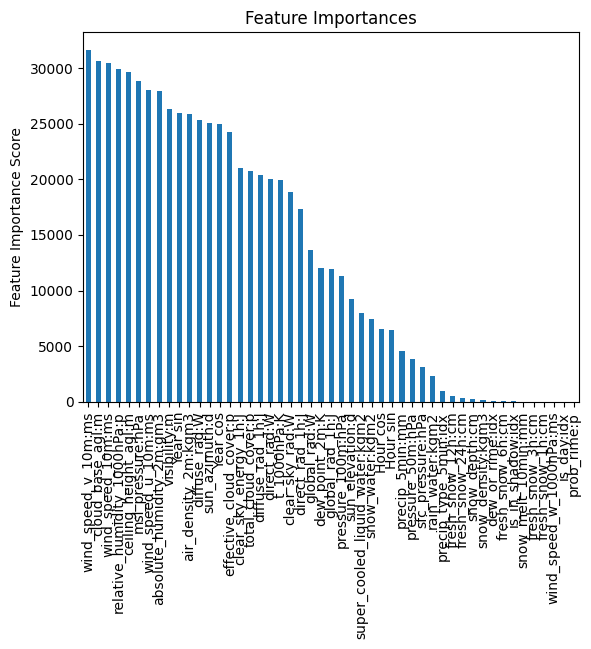

In [67]:
model_b = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=2880,
 max_depth=10,
 min_child_weight=2,
 gamma=6.9462927163070525,
 subsample=0.5425452253269976,
 colsample_bytree=0.8615770908405836,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha = 39.56391755892025,
 reg_lambda = 165.13746485969003,
)

modelfit(model_b, data.B.train_x, data.B.train_y, data.B.val_x, data.B.val_y, useTrainCV = False)

[0]	train-mae:125.99382+0.63387	test-mae:126.03043+1.38714
[1]	train-mae:120.73055+0.61819	test-mae:120.82261+1.31004
[2]	train-mae:115.69034+0.60587	test-mae:115.81959+1.25571
[3]	train-mae:110.93249+0.59693	test-mae:111.10465+1.22021
[4]	train-mae:106.43215+0.56954	test-mae:106.63894+1.20150
[5]	train-mae:102.20539+0.54308	test-mae:102.46179+1.15187
[6]	train-mae:98.14402+0.52782	test-mae:98.43715+1.12412
[7]	train-mae:94.31203+0.50714	test-mae:94.64724+1.09796
[8]	train-mae:90.69959+0.47208	test-mae:91.07443+1.08076
[9]	train-mae:87.29151+0.43163	test-mae:87.71086+1.07702
[10]	train-mae:84.03325+0.41850	test-mae:84.50083+1.05287
[11]	train-mae:80.96933+0.40771	test-mae:81.47396+1.03897
[12]	train-mae:78.06975+0.40073	test-mae:78.62040+1.01859
[13]	train-mae:75.29593+0.38605	test-mae:75.88947+1.01027
[14]	train-mae:72.66706+0.37379	test-mae:73.29960+0.97507
[15]	train-mae:70.17931+0.36181	test-mae:70.85340+0.96421
[16]	train-mae:67.85131+0.34321	test-mae:68.58918+0.94873
[17]	train-m

[141]	train-mae:19.51702+0.21569	test-mae:25.24144+0.67843
[142]	train-mae:19.46950+0.21900	test-mae:25.22668+0.67915
[143]	train-mae:19.42493+0.21789	test-mae:25.20676+0.67779
[144]	train-mae:19.37849+0.21597	test-mae:25.18969+0.67797
[145]	train-mae:19.33188+0.21635	test-mae:25.17313+0.67819
[146]	train-mae:19.29076+0.21246	test-mae:25.16198+0.67780
[147]	train-mae:19.25152+0.21298	test-mae:25.14871+0.68232
[148]	train-mae:19.21414+0.21039	test-mae:25.13905+0.68276
[149]	train-mae:19.17780+0.21271	test-mae:25.13258+0.68323
[150]	train-mae:19.13851+0.20784	test-mae:25.12221+0.68625
[151]	train-mae:19.09427+0.21034	test-mae:25.11232+0.68044
[152]	train-mae:19.05672+0.20810	test-mae:25.10015+0.68203
[153]	train-mae:19.02356+0.21224	test-mae:25.08868+0.68162
[154]	train-mae:18.98546+0.21503	test-mae:25.07544+0.68267
[155]	train-mae:18.94268+0.21063	test-mae:25.06241+0.68246
[156]	train-mae:18.90550+0.21472	test-mae:25.05283+0.68006
[157]	train-mae:18.87103+0.21886	test-mae:25.04161+0.680

[280]	train-mae:14.96720+0.19373	test-mae:24.20627+0.59538
[281]	train-mae:14.93943+0.19709	test-mae:24.20111+0.59468
[282]	train-mae:14.91679+0.19256	test-mae:24.19663+0.59583
[283]	train-mae:14.89362+0.19197	test-mae:24.19177+0.59367
[284]	train-mae:14.86788+0.19245	test-mae:24.18714+0.59231
[285]	train-mae:14.83976+0.19084	test-mae:24.18113+0.59342
[286]	train-mae:14.81265+0.18961	test-mae:24.17309+0.59201
[287]	train-mae:14.78600+0.19254	test-mae:24.17084+0.58837
[288]	train-mae:14.76134+0.19243	test-mae:24.16755+0.58281
[289]	train-mae:14.73948+0.19499	test-mae:24.16532+0.57990
[290]	train-mae:14.71611+0.19529	test-mae:24.16107+0.58078
[291]	train-mae:14.69172+0.19322	test-mae:24.15849+0.58022
[292]	train-mae:14.66753+0.19056	test-mae:24.15347+0.57898
[293]	train-mae:14.64468+0.18780	test-mae:24.14629+0.57996
[294]	train-mae:14.62078+0.18723	test-mae:24.14598+0.57943
[295]	train-mae:14.59734+0.18885	test-mae:24.14133+0.57921
[296]	train-mae:14.57377+0.18770	test-mae:24.13675+0.578

[419]	train-mae:12.04313+0.13072	test-mae:23.73067+0.54845
[420]	train-mae:12.02783+0.13109	test-mae:23.72895+0.54956
[421]	train-mae:12.01048+0.12968	test-mae:23.72642+0.54880
[422]	train-mae:11.99271+0.12436	test-mae:23.72129+0.54852
[423]	train-mae:11.97126+0.12440	test-mae:23.71708+0.54676
[424]	train-mae:11.94987+0.12616	test-mae:23.71395+0.54654
[425]	train-mae:11.93162+0.12645	test-mae:23.71227+0.54590
[426]	train-mae:11.91633+0.12690	test-mae:23.70982+0.54560
[427]	train-mae:11.89943+0.12370	test-mae:23.70943+0.54601
[428]	train-mae:11.88064+0.12411	test-mae:23.70529+0.54689
[429]	train-mae:11.86164+0.12374	test-mae:23.70324+0.54765
[430]	train-mae:11.84565+0.12253	test-mae:23.70197+0.54485
[431]	train-mae:11.82991+0.12358	test-mae:23.70025+0.54268
[432]	train-mae:11.81311+0.12521	test-mae:23.69760+0.54326
[433]	train-mae:11.79826+0.12256	test-mae:23.69608+0.54089
[434]	train-mae:11.78109+0.12110	test-mae:23.69225+0.53830
[435]	train-mae:11.76363+0.12172	test-mae:23.68722+0.537

[558]	train-mae:9.93900+0.07708	test-mae:23.44943+0.52244
[559]	train-mae:9.92686+0.07597	test-mae:23.44612+0.52175
[560]	train-mae:9.91431+0.07652	test-mae:23.44316+0.52246
[561]	train-mae:9.90200+0.07457	test-mae:23.43993+0.52503
[562]	train-mae:9.89080+0.07561	test-mae:23.43709+0.52543
[563]	train-mae:9.87964+0.07630	test-mae:23.43845+0.52552
[564]	train-mae:9.86756+0.07522	test-mae:23.43803+0.52502
[565]	train-mae:9.85520+0.07711	test-mae:23.43736+0.52578
[566]	train-mae:9.84289+0.07662	test-mae:23.43610+0.52729
[567]	train-mae:9.83232+0.07693	test-mae:23.43528+0.52690
[568]	train-mae:9.81860+0.07889	test-mae:23.43462+0.52657
[569]	train-mae:9.80489+0.07866	test-mae:23.43330+0.52480
[570]	train-mae:9.79241+0.07839	test-mae:23.43218+0.52371
[571]	train-mae:9.77737+0.07880	test-mae:23.43012+0.52455
[572]	train-mae:9.76479+0.07801	test-mae:23.42794+0.52478
[573]	train-mae:9.75346+0.07879	test-mae:23.42629+0.52345
[574]	train-mae:9.73997+0.07944	test-mae:23.42150+0.52415
[575]	train-ma

[700]	train-mae:8.32646+0.05639	test-mae:23.24174+0.50537
[701]	train-mae:8.31730+0.05669	test-mae:23.24034+0.50429
[702]	train-mae:8.30732+0.05642	test-mae:23.23843+0.50447
[703]	train-mae:8.29693+0.05587	test-mae:23.23721+0.50556
[704]	train-mae:8.28741+0.05483	test-mae:23.23602+0.50654
[705]	train-mae:8.27951+0.05485	test-mae:23.23587+0.50550
[706]	train-mae:8.26928+0.05531	test-mae:23.23500+0.50559
[707]	train-mae:8.26044+0.05510	test-mae:23.23522+0.50591
[708]	train-mae:8.25040+0.05576	test-mae:23.23432+0.50474
[709]	train-mae:8.23970+0.05446	test-mae:23.23286+0.50527
[710]	train-mae:8.23021+0.05368	test-mae:23.23241+0.50462
[711]	train-mae:8.22138+0.05324	test-mae:23.23194+0.50361
[712]	train-mae:8.21106+0.05267	test-mae:23.23048+0.50284
[713]	train-mae:8.20111+0.05337	test-mae:23.23139+0.50250
[714]	train-mae:8.19159+0.05371	test-mae:23.22926+0.50276
[715]	train-mae:8.18298+0.05422	test-mae:23.22847+0.50252
[716]	train-mae:8.17370+0.05346	test-mae:23.22631+0.50182
[717]	train-ma

[842]	train-mae:7.09259+0.04384	test-mae:23.09018+0.49208
[843]	train-mae:7.08525+0.04447	test-mae:23.09016+0.49399
[844]	train-mae:7.07781+0.04447	test-mae:23.08997+0.49372
[845]	train-mae:7.07102+0.04477	test-mae:23.08911+0.49378
[846]	train-mae:7.06293+0.04388	test-mae:23.08699+0.49354
[847]	train-mae:7.05420+0.04387	test-mae:23.08549+0.49259
[848]	train-mae:7.04664+0.04302	test-mae:23.08528+0.49248
[849]	train-mae:7.03873+0.04333	test-mae:23.08356+0.49257
[850]	train-mae:7.03082+0.04288	test-mae:23.08329+0.49334
[851]	train-mae:7.02400+0.04335	test-mae:23.08253+0.49415
[852]	train-mae:7.01679+0.04391	test-mae:23.08249+0.49420
[853]	train-mae:7.00850+0.04408	test-mae:23.08123+0.49450
[854]	train-mae:7.00182+0.04387	test-mae:23.07936+0.49377
[855]	train-mae:6.99375+0.04397	test-mae:23.07732+0.49461
[856]	train-mae:6.98519+0.04377	test-mae:23.07731+0.49500
[857]	train-mae:6.97722+0.04390	test-mae:23.07669+0.49446
[858]	train-mae:6.96865+0.04314	test-mae:23.07495+0.49406
[859]	train-ma

[984]	train-mae:6.11876+0.03563	test-mae:22.98160+0.48068
[985]	train-mae:6.11258+0.03494	test-mae:22.98059+0.48059
[986]	train-mae:6.10665+0.03507	test-mae:22.97956+0.48001
[987]	train-mae:6.10131+0.03488	test-mae:22.97947+0.48051
[988]	train-mae:6.09455+0.03475	test-mae:22.97810+0.48040
[989]	train-mae:6.08899+0.03518	test-mae:22.97751+0.48014
[990]	train-mae:6.08245+0.03542	test-mae:22.97673+0.48072
[991]	train-mae:6.07705+0.03608	test-mae:22.97595+0.48028
[992]	train-mae:6.07204+0.03582	test-mae:22.97500+0.47985
[993]	train-mae:6.06616+0.03536	test-mae:22.97436+0.47995
[994]	train-mae:6.05976+0.03429	test-mae:22.97373+0.47925
[995]	train-mae:6.05430+0.03432	test-mae:22.97421+0.47929
[996]	train-mae:6.04815+0.03421	test-mae:22.97271+0.47864
[997]	train-mae:6.04212+0.03407	test-mae:22.97287+0.47833
[998]	train-mae:6.03565+0.03433	test-mae:22.97258+0.47800
[999]	train-mae:6.03052+0.03416	test-mae:22.97213+0.47715
[1000]	train-mae:6.02460+0.03435	test-mae:22.97160+0.47662
[1001]	train-

[1124]	train-mae:5.36865+0.03003	test-mae:22.90424+0.46513
[1125]	train-mae:5.36374+0.03021	test-mae:22.90391+0.46463
[1126]	train-mae:5.35923+0.02980	test-mae:22.90441+0.46427
[1127]	train-mae:5.35424+0.02991	test-mae:22.90382+0.46446
[1128]	train-mae:5.34868+0.02974	test-mae:22.90290+0.46402
[1129]	train-mae:5.34414+0.03015	test-mae:22.90268+0.46349
[1130]	train-mae:5.33961+0.03017	test-mae:22.90224+0.46319
[1131]	train-mae:5.33469+0.03074	test-mae:22.90161+0.46224
[1132]	train-mae:5.33002+0.03072	test-mae:22.90125+0.46150
[1133]	train-mae:5.32546+0.03059	test-mae:22.90163+0.46171
[1134]	train-mae:5.32060+0.03064	test-mae:22.90034+0.46147
[1135]	train-mae:5.31616+0.03054	test-mae:22.90011+0.46151
[1136]	train-mae:5.31200+0.03021	test-mae:22.89943+0.46094
[1137]	train-mae:5.30748+0.03005	test-mae:22.89924+0.46150
[1138]	train-mae:5.30286+0.03007	test-mae:22.89850+0.46163
[1139]	train-mae:5.29750+0.03032	test-mae:22.89731+0.46133
[1140]	train-mae:5.29299+0.03067	test-mae:22.89730+0.461

[1263]	train-mae:4.77749+0.03223	test-mae:22.84227+0.45852
[1264]	train-mae:4.77394+0.03200	test-mae:22.84138+0.45806
[1265]	train-mae:4.77045+0.03193	test-mae:22.84138+0.45792
[1266]	train-mae:4.76676+0.03218	test-mae:22.84003+0.45836
[1267]	train-mae:4.76318+0.03217	test-mae:22.83984+0.45821
[1268]	train-mae:4.75915+0.03206	test-mae:22.83945+0.45766
[1269]	train-mae:4.75535+0.03191	test-mae:22.83935+0.45753
[1270]	train-mae:4.75160+0.03203	test-mae:22.83835+0.45729
[1271]	train-mae:4.74741+0.03217	test-mae:22.83749+0.45780
[1272]	train-mae:4.74379+0.03218	test-mae:22.83744+0.45788
[1273]	train-mae:4.74010+0.03163	test-mae:22.83691+0.45772
[1274]	train-mae:4.73581+0.03163	test-mae:22.83622+0.45723
[1275]	train-mae:4.73236+0.03174	test-mae:22.83602+0.45761
[1276]	train-mae:4.72811+0.03152	test-mae:22.83539+0.45812
[1277]	train-mae:4.72435+0.03131	test-mae:22.83503+0.45822
[1278]	train-mae:4.72024+0.03104	test-mae:22.83485+0.45906
[1279]	train-mae:4.71624+0.03104	test-mae:22.83404+0.459

[1402]	train-mae:4.29500+0.03263	test-mae:22.78536+0.46143
[1403]	train-mae:4.29231+0.03259	test-mae:22.78507+0.46159
[1404]	train-mae:4.28894+0.03256	test-mae:22.78505+0.46173
[1405]	train-mae:4.28559+0.03249	test-mae:22.78481+0.46151
[1406]	train-mae:4.28268+0.03221	test-mae:22.78455+0.46157
[1407]	train-mae:4.27960+0.03210	test-mae:22.78475+0.46121
[1408]	train-mae:4.27669+0.03191	test-mae:22.78483+0.46093
[1409]	train-mae:4.27364+0.03216	test-mae:22.78454+0.46110
[1410]	train-mae:4.27092+0.03211	test-mae:22.78421+0.46128
[1411]	train-mae:4.26758+0.03223	test-mae:22.78371+0.46101
[1412]	train-mae:4.26420+0.03243	test-mae:22.78300+0.46119
[1413]	train-mae:4.26154+0.03239	test-mae:22.78275+0.46119
[1414]	train-mae:4.25803+0.03254	test-mae:22.78280+0.46052
[1415]	train-mae:4.25470+0.03252	test-mae:22.78208+0.46121
[1416]	train-mae:4.25189+0.03282	test-mae:22.78231+0.46175
[1417]	train-mae:4.24885+0.03264	test-mae:22.78252+0.46106
[1418]	train-mae:4.24650+0.03239	test-mae:22.78248+0.461

[1541]	train-mae:3.90547+0.02892	test-mae:22.75321+0.46165
[1542]	train-mae:3.90289+0.02895	test-mae:22.75363+0.46149
[1543]	train-mae:3.90031+0.02898	test-mae:22.75370+0.46147
[1544]	train-mae:3.89808+0.02897	test-mae:22.75379+0.46076
[1545]	train-mae:3.89542+0.02868	test-mae:22.75320+0.46096
[1546]	train-mae:3.89271+0.02837	test-mae:22.75274+0.46077
[1547]	train-mae:3.89023+0.02834	test-mae:22.75224+0.46111
[1548]	train-mae:3.88781+0.02831	test-mae:22.75235+0.46111
[1549]	train-mae:3.88515+0.02818	test-mae:22.75193+0.46113
[1550]	train-mae:3.88308+0.02806	test-mae:22.75214+0.46142
[1551]	train-mae:3.88105+0.02818	test-mae:22.75203+0.46195
[1552]	train-mae:3.87856+0.02810	test-mae:22.75176+0.46152
[1553]	train-mae:3.87566+0.02794	test-mae:22.75156+0.46180
[1554]	train-mae:3.87340+0.02753	test-mae:22.75118+0.46237
[1555]	train-mae:3.87096+0.02768	test-mae:22.75125+0.46179
[1556]	train-mae:3.86813+0.02769	test-mae:22.75062+0.46116
[1557]	train-mae:3.86556+0.02790	test-mae:22.75070+0.461

[1680]	train-mae:3.58699+0.02697	test-mae:22.71762+0.46262
[1681]	train-mae:3.58493+0.02691	test-mae:22.71766+0.46217
[1682]	train-mae:3.58278+0.02714	test-mae:22.71727+0.46236
[1683]	train-mae:3.58068+0.02678	test-mae:22.71678+0.46230
[1684]	train-mae:3.57884+0.02672	test-mae:22.71706+0.46236
[1685]	train-mae:3.57677+0.02657	test-mae:22.71695+0.46248
[1686]	train-mae:3.57452+0.02651	test-mae:22.71663+0.46255
[1687]	train-mae:3.57253+0.02660	test-mae:22.71587+0.46303
[1688]	train-mae:3.57051+0.02642	test-mae:22.71568+0.46314
[1689]	train-mae:3.56846+0.02639	test-mae:22.71505+0.46270
[1690]	train-mae:3.56601+0.02623	test-mae:22.71507+0.46223
[1691]	train-mae:3.56390+0.02631	test-mae:22.71467+0.46197
[1692]	train-mae:3.56173+0.02622	test-mae:22.71419+0.46166
[1693]	train-mae:3.55994+0.02636	test-mae:22.71403+0.46177
[1694]	train-mae:3.55790+0.02609	test-mae:22.71379+0.46206
[1695]	train-mae:3.55581+0.02608	test-mae:22.71338+0.46181
[1696]	train-mae:3.55407+0.02579	test-mae:22.71334+0.461

[1819]	train-mae:3.32385+0.02197	test-mae:22.68413+0.46087
[1820]	train-mae:3.32208+0.02201	test-mae:22.68424+0.46109
[1821]	train-mae:3.32040+0.02224	test-mae:22.68392+0.46088
[1822]	train-mae:3.31897+0.02226	test-mae:22.68414+0.46065
[1823]	train-mae:3.31755+0.02228	test-mae:22.68386+0.46073
[1824]	train-mae:3.31594+0.02218	test-mae:22.68382+0.46036
[1825]	train-mae:3.31421+0.02217	test-mae:22.68371+0.46069
[1826]	train-mae:3.31250+0.02220	test-mae:22.68308+0.46106
[1827]	train-mae:3.31105+0.02233	test-mae:22.68319+0.46126
[1828]	train-mae:3.30923+0.02219	test-mae:22.68292+0.46126
[1829]	train-mae:3.30763+0.02205	test-mae:22.68293+0.46090
[1830]	train-mae:3.30570+0.02199	test-mae:22.68243+0.46088
[1831]	train-mae:3.30410+0.02197	test-mae:22.68254+0.46083
[1832]	train-mae:3.30227+0.02193	test-mae:22.68249+0.46096
[1833]	train-mae:3.30102+0.02192	test-mae:22.68248+0.46071
[1834]	train-mae:3.29946+0.02214	test-mae:22.68210+0.46069
[1835]	train-mae:3.29753+0.02229	test-mae:22.68199+0.460

[1958]	train-mae:3.10287+0.01949	test-mae:22.65839+0.45673
[1959]	train-mae:3.10126+0.01941	test-mae:22.65843+0.45637
[1960]	train-mae:3.10010+0.01933	test-mae:22.65832+0.45636
[1961]	train-mae:3.09890+0.01930	test-mae:22.65820+0.45594
[1962]	train-mae:3.09754+0.01906	test-mae:22.65822+0.45588
[1963]	train-mae:3.09624+0.01916	test-mae:22.65767+0.45561
[1964]	train-mae:3.09453+0.01910	test-mae:22.65743+0.45534
[1965]	train-mae:3.09316+0.01900	test-mae:22.65700+0.45498
[1966]	train-mae:3.09153+0.01893	test-mae:22.65652+0.45512
[1967]	train-mae:3.09014+0.01889	test-mae:22.65677+0.45530
[1968]	train-mae:3.08836+0.01926	test-mae:22.65644+0.45562
[1969]	train-mae:3.08664+0.01916	test-mae:22.65618+0.45515
[1970]	train-mae:3.08539+0.01920	test-mae:22.65600+0.45549
[1971]	train-mae:3.08401+0.01918	test-mae:22.65567+0.45519
[1972]	train-mae:3.08264+0.01888	test-mae:22.65581+0.45528
[1973]	train-mae:3.08147+0.01893	test-mae:22.65561+0.45522
[1974]	train-mae:3.08027+0.01895	test-mae:22.65553+0.455

[40]	validation_0-mae:36.19575	validation_1-mae:31.36928
[41]	validation_0-mae:35.54747	validation_1-mae:30.85637
[42]	validation_0-mae:34.95092	validation_1-mae:30.39675
[43]	validation_0-mae:34.38204	validation_1-mae:29.95860
[44]	validation_0-mae:33.84098	validation_1-mae:29.55047
[45]	validation_0-mae:33.29384	validation_1-mae:29.14064
[46]	validation_0-mae:32.80483	validation_1-mae:28.75541
[47]	validation_0-mae:32.30667	validation_1-mae:28.39781
[48]	validation_0-mae:31.84472	validation_1-mae:28.06555
[49]	validation_0-mae:31.41994	validation_1-mae:27.73698
[50]	validation_0-mae:31.00205	validation_1-mae:27.41793
[51]	validation_0-mae:30.60926	validation_1-mae:27.12039
[52]	validation_0-mae:30.21938	validation_1-mae:26.83328
[53]	validation_0-mae:29.84742	validation_1-mae:26.57744
[54]	validation_0-mae:29.48411	validation_1-mae:26.34029
[55]	validation_0-mae:29.15460	validation_1-mae:26.09589
[56]	validation_0-mae:28.82410	validation_1-mae:25.86968
[57]	validation_0-mae:28.53446	

[183]	validation_0-mae:17.75536	validation_1-mae:22.19188
[184]	validation_0-mae:17.72509	validation_1-mae:22.18787
[185]	validation_0-mae:17.69105	validation_1-mae:22.18413
[186]	validation_0-mae:17.65382	validation_1-mae:22.19381
[187]	validation_0-mae:17.62316	validation_1-mae:22.19146
[188]	validation_0-mae:17.59237	validation_1-mae:22.18937
[189]	validation_0-mae:17.56570	validation_1-mae:22.18874
[190]	validation_0-mae:17.53112	validation_1-mae:22.18685
[191]	validation_0-mae:17.50334	validation_1-mae:22.19310
[192]	validation_0-mae:17.47325	validation_1-mae:22.19434
[193]	validation_0-mae:17.43633	validation_1-mae:22.19115
[194]	validation_0-mae:17.40564	validation_1-mae:22.19909
[195]	validation_0-mae:17.37562	validation_1-mae:22.19839
[196]	validation_0-mae:17.34858	validation_1-mae:22.21300
[197]	validation_0-mae:17.31913	validation_1-mae:22.20686
[198]	validation_0-mae:17.27870	validation_1-mae:22.21165
[199]	validation_0-mae:17.23834	validation_1-mae:22.21310
[200]	validati

[325]	validation_0-mae:13.80873	validation_1-mae:22.41797
[326]	validation_0-mae:13.78227	validation_1-mae:22.41967
[327]	validation_0-mae:13.76173	validation_1-mae:22.41960
[328]	validation_0-mae:13.74353	validation_1-mae:22.41649
[329]	validation_0-mae:13.72392	validation_1-mae:22.41868
[330]	validation_0-mae:13.70295	validation_1-mae:22.41947
[331]	validation_0-mae:13.68325	validation_1-mae:22.42139
[332]	validation_0-mae:13.65676	validation_1-mae:22.42226
[333]	validation_0-mae:13.62787	validation_1-mae:22.42450
[334]	validation_0-mae:13.60866	validation_1-mae:22.42879
[335]	validation_0-mae:13.59372	validation_1-mae:22.43041
[336]	validation_0-mae:13.57244	validation_1-mae:22.43166
[337]	validation_0-mae:13.56167	validation_1-mae:22.43091
[338]	validation_0-mae:13.53941	validation_1-mae:22.42912
[339]	validation_0-mae:13.52212	validation_1-mae:22.42712
[340]	validation_0-mae:13.49706	validation_1-mae:22.42781
[341]	validation_0-mae:13.48367	validation_1-mae:22.42863
[342]	validati

[467]	validation_0-mae:11.20049	validation_1-mae:22.55632
[468]	validation_0-mae:11.18891	validation_1-mae:22.55716
[469]	validation_0-mae:11.17213	validation_1-mae:22.56056
[470]	validation_0-mae:11.15209	validation_1-mae:22.56325
[471]	validation_0-mae:11.14002	validation_1-mae:22.56403
[472]	validation_0-mae:11.12493	validation_1-mae:22.56748
[473]	validation_0-mae:11.11124	validation_1-mae:22.57083
[474]	validation_0-mae:11.09603	validation_1-mae:22.56995
[475]	validation_0-mae:11.08312	validation_1-mae:22.57493
[476]	validation_0-mae:11.06703	validation_1-mae:22.57405
[477]	validation_0-mae:11.05017	validation_1-mae:22.57992
[478]	validation_0-mae:11.03223	validation_1-mae:22.58121
[479]	validation_0-mae:11.02011	validation_1-mae:22.57958
[480]	validation_0-mae:11.00233	validation_1-mae:22.58124
[481]	validation_0-mae:10.99024	validation_1-mae:22.58084
[482]	validation_0-mae:10.97728	validation_1-mae:22.57962
[483]	validation_0-mae:10.96600	validation_1-mae:22.58088
[484]	validati

[610]	validation_0-mae:9.35339	validation_1-mae:22.63974
[611]	validation_0-mae:9.34128	validation_1-mae:22.64071
[612]	validation_0-mae:9.33462	validation_1-mae:22.64105
[613]	validation_0-mae:9.32321	validation_1-mae:22.64368
[614]	validation_0-mae:9.31318	validation_1-mae:22.64338
[615]	validation_0-mae:9.29857	validation_1-mae:22.64348
[616]	validation_0-mae:9.28872	validation_1-mae:22.64601
[617]	validation_0-mae:9.27932	validation_1-mae:22.64609
[618]	validation_0-mae:9.27084	validation_1-mae:22.64548
[619]	validation_0-mae:9.25653	validation_1-mae:22.64559
[620]	validation_0-mae:9.24720	validation_1-mae:22.64850
[621]	validation_0-mae:9.23588	validation_1-mae:22.64888
[622]	validation_0-mae:9.22721	validation_1-mae:22.64978
[623]	validation_0-mae:9.21444	validation_1-mae:22.65203
[624]	validation_0-mae:9.20274	validation_1-mae:22.65462
[625]	validation_0-mae:9.19520	validation_1-mae:22.65467
[626]	validation_0-mae:9.18272	validation_1-mae:22.65705
[627]	validation_0-mae:9.17407	

[754]	validation_0-mae:7.90607	validation_1-mae:22.72966
[755]	validation_0-mae:7.89353	validation_1-mae:22.73058
[756]	validation_0-mae:7.88194	validation_1-mae:22.72956
[757]	validation_0-mae:7.87454	validation_1-mae:22.73075
[758]	validation_0-mae:7.86639	validation_1-mae:22.73069
[759]	validation_0-mae:7.85762	validation_1-mae:22.73441
[760]	validation_0-mae:7.84986	validation_1-mae:22.73425
[761]	validation_0-mae:7.84319	validation_1-mae:22.73594
[762]	validation_0-mae:7.83495	validation_1-mae:22.73820
[763]	validation_0-mae:7.82109	validation_1-mae:22.74108
[764]	validation_0-mae:7.81016	validation_1-mae:22.74061
[765]	validation_0-mae:7.79881	validation_1-mae:22.74166
[766]	validation_0-mae:7.79020	validation_1-mae:22.74061
[767]	validation_0-mae:7.78071	validation_1-mae:22.74120
[768]	validation_0-mae:7.77445	validation_1-mae:22.74097
[769]	validation_0-mae:7.76303	validation_1-mae:22.74306
[770]	validation_0-mae:7.75333	validation_1-mae:22.74500
[771]	validation_0-mae:7.74358	

[898]	validation_0-mae:6.75288	validation_1-mae:22.80439
[899]	validation_0-mae:6.74678	validation_1-mae:22.80390
[900]	validation_0-mae:6.73635	validation_1-mae:22.80273
[901]	validation_0-mae:6.72869	validation_1-mae:22.80143
[902]	validation_0-mae:6.72094	validation_1-mae:22.80070
[903]	validation_0-mae:6.71424	validation_1-mae:22.79834
[904]	validation_0-mae:6.70718	validation_1-mae:22.79743
[905]	validation_0-mae:6.69927	validation_1-mae:22.79609
[906]	validation_0-mae:6.69282	validation_1-mae:22.79727
[907]	validation_0-mae:6.68449	validation_1-mae:22.80004
[908]	validation_0-mae:6.67738	validation_1-mae:22.80215
[909]	validation_0-mae:6.67026	validation_1-mae:22.80167
[910]	validation_0-mae:6.66400	validation_1-mae:22.80072
[911]	validation_0-mae:6.65767	validation_1-mae:22.80198
[912]	validation_0-mae:6.65058	validation_1-mae:22.80367
[913]	validation_0-mae:6.64216	validation_1-mae:22.80516
[914]	validation_0-mae:6.63616	validation_1-mae:22.80604
[915]	validation_0-mae:6.63072	

[1042]	validation_0-mae:5.84772	validation_1-mae:22.84372
[1043]	validation_0-mae:5.84160	validation_1-mae:22.84771
[1044]	validation_0-mae:5.83692	validation_1-mae:22.85064
[1045]	validation_0-mae:5.83257	validation_1-mae:22.85073
[1046]	validation_0-mae:5.82630	validation_1-mae:22.85218
[1047]	validation_0-mae:5.82154	validation_1-mae:22.85292
[1048]	validation_0-mae:5.81745	validation_1-mae:22.85321
[1049]	validation_0-mae:5.81050	validation_1-mae:22.85226
[1050]	validation_0-mae:5.80538	validation_1-mae:22.85303
[1051]	validation_0-mae:5.79977	validation_1-mae:22.85086
[1052]	validation_0-mae:5.79260	validation_1-mae:22.84977
[1053]	validation_0-mae:5.78580	validation_1-mae:22.84660
[1054]	validation_0-mae:5.78079	validation_1-mae:22.84629
[1055]	validation_0-mae:5.77450	validation_1-mae:22.84677
[1056]	validation_0-mae:5.76887	validation_1-mae:22.84788
[1057]	validation_0-mae:5.76417	validation_1-mae:22.84702
[1058]	validation_0-mae:5.75750	validation_1-mae:22.84644
[1059]	validat

[1184]	validation_0-mae:5.14460	validation_1-mae:22.87737
[1185]	validation_0-mae:5.13916	validation_1-mae:22.87683
[1186]	validation_0-mae:5.13498	validation_1-mae:22.87638
[1187]	validation_0-mae:5.13037	validation_1-mae:22.87649
[1188]	validation_0-mae:5.12721	validation_1-mae:22.87851
[1189]	validation_0-mae:5.12216	validation_1-mae:22.87964
[1190]	validation_0-mae:5.11803	validation_1-mae:22.87999
[1191]	validation_0-mae:5.11333	validation_1-mae:22.87900
[1192]	validation_0-mae:5.10956	validation_1-mae:22.88074
[1193]	validation_0-mae:5.10556	validation_1-mae:22.88024
[1194]	validation_0-mae:5.10115	validation_1-mae:22.88170
[1195]	validation_0-mae:5.09756	validation_1-mae:22.88237
[1196]	validation_0-mae:5.09392	validation_1-mae:22.88300
[1197]	validation_0-mae:5.09149	validation_1-mae:22.88419
[1198]	validation_0-mae:5.08851	validation_1-mae:22.88468
[1199]	validation_0-mae:5.08345	validation_1-mae:22.88422
[1200]	validation_0-mae:5.07973	validation_1-mae:22.88393
[1201]	validat

[1326]	validation_0-mae:4.59881	validation_1-mae:22.90208
[1327]	validation_0-mae:4.59548	validation_1-mae:22.90119
[1328]	validation_0-mae:4.59080	validation_1-mae:22.90196
[1329]	validation_0-mae:4.58853	validation_1-mae:22.90183
[1330]	validation_0-mae:4.58524	validation_1-mae:22.90279
[1331]	validation_0-mae:4.58198	validation_1-mae:22.90284
[1332]	validation_0-mae:4.57843	validation_1-mae:22.90384
[1333]	validation_0-mae:4.57504	validation_1-mae:22.90430
[1334]	validation_0-mae:4.57288	validation_1-mae:22.90396
[1335]	validation_0-mae:4.56920	validation_1-mae:22.90364
[1336]	validation_0-mae:4.56515	validation_1-mae:22.90200
[1337]	validation_0-mae:4.56088	validation_1-mae:22.90157
[1338]	validation_0-mae:4.55751	validation_1-mae:22.90293
[1339]	validation_0-mae:4.55489	validation_1-mae:22.90363
[1340]	validation_0-mae:4.55108	validation_1-mae:22.90394
[1341]	validation_0-mae:4.54718	validation_1-mae:22.90421
[1342]	validation_0-mae:4.54436	validation_1-mae:22.90491
[1343]	validat

[1468]	validation_0-mae:4.14033	validation_1-mae:22.92456
[1469]	validation_0-mae:4.13734	validation_1-mae:22.92506
[1470]	validation_0-mae:4.13425	validation_1-mae:22.92580
[1471]	validation_0-mae:4.13153	validation_1-mae:22.92613
[1472]	validation_0-mae:4.12840	validation_1-mae:22.92530
[1473]	validation_0-mae:4.12609	validation_1-mae:22.92533
[1474]	validation_0-mae:4.12261	validation_1-mae:22.92606
[1475]	validation_0-mae:4.11941	validation_1-mae:22.92776
[1476]	validation_0-mae:4.11723	validation_1-mae:22.92660
[1477]	validation_0-mae:4.11388	validation_1-mae:22.92718
[1478]	validation_0-mae:4.11068	validation_1-mae:22.92718
[1479]	validation_0-mae:4.10838	validation_1-mae:22.92558
[1480]	validation_0-mae:4.10480	validation_1-mae:22.92714
[1481]	validation_0-mae:4.10200	validation_1-mae:22.92685
[1482]	validation_0-mae:4.09934	validation_1-mae:22.92690
[1483]	validation_0-mae:4.09681	validation_1-mae:22.92697
[1484]	validation_0-mae:4.09366	validation_1-mae:22.92683
[1485]	validat

[1610]	validation_0-mae:3.77084	validation_1-mae:22.94111
[1611]	validation_0-mae:3.76818	validation_1-mae:22.94226
[1612]	validation_0-mae:3.76534	validation_1-mae:22.94169
[1613]	validation_0-mae:3.76282	validation_1-mae:22.94186
[1614]	validation_0-mae:3.76057	validation_1-mae:22.94193
[1615]	validation_0-mae:3.75792	validation_1-mae:22.94060
[1616]	validation_0-mae:3.75520	validation_1-mae:22.94015
[1617]	validation_0-mae:3.75257	validation_1-mae:22.93961
[1618]	validation_0-mae:3.75038	validation_1-mae:22.93932
[1619]	validation_0-mae:3.74777	validation_1-mae:22.93793
[1620]	validation_0-mae:3.74520	validation_1-mae:22.93736
[1621]	validation_0-mae:3.74244	validation_1-mae:22.93631
[1622]	validation_0-mae:3.73945	validation_1-mae:22.93712
[1623]	validation_0-mae:3.73646	validation_1-mae:22.93702
[1624]	validation_0-mae:3.73451	validation_1-mae:22.93735
[1625]	validation_0-mae:3.73180	validation_1-mae:22.93712
[1626]	validation_0-mae:3.72893	validation_1-mae:22.93700
[1627]	validat

[1752]	validation_0-mae:3.45948	validation_1-mae:22.95720
[1753]	validation_0-mae:3.45739	validation_1-mae:22.95661
[1754]	validation_0-mae:3.45553	validation_1-mae:22.95752
[1755]	validation_0-mae:3.45384	validation_1-mae:22.95816
[1756]	validation_0-mae:3.45179	validation_1-mae:22.95839
[1757]	validation_0-mae:3.45030	validation_1-mae:22.95993
[1758]	validation_0-mae:3.44828	validation_1-mae:22.96000
[1759]	validation_0-mae:3.44594	validation_1-mae:22.95959
[1760]	validation_0-mae:3.44355	validation_1-mae:22.96057
[1761]	validation_0-mae:3.44154	validation_1-mae:22.96091
[1762]	validation_0-mae:3.43954	validation_1-mae:22.96059
[1763]	validation_0-mae:3.43748	validation_1-mae:22.96057
[1764]	validation_0-mae:3.43553	validation_1-mae:22.95982
[1765]	validation_0-mae:3.43334	validation_1-mae:22.95949
[1766]	validation_0-mae:3.43178	validation_1-mae:22.96057
[1767]	validation_0-mae:3.42955	validation_1-mae:22.95972
[1768]	validation_0-mae:3.42771	validation_1-mae:22.96041
[1769]	validat

[1894]	validation_0-mae:3.20844	validation_1-mae:22.97207
[1895]	validation_0-mae:3.20663	validation_1-mae:22.97343
[1896]	validation_0-mae:3.20477	validation_1-mae:22.97305
[1897]	validation_0-mae:3.20288	validation_1-mae:22.97311
[1898]	validation_0-mae:3.20117	validation_1-mae:22.97329
[1899]	validation_0-mae:3.19919	validation_1-mae:22.97301
[1900]	validation_0-mae:3.19725	validation_1-mae:22.97238
[1901]	validation_0-mae:3.19568	validation_1-mae:22.97270
[1902]	validation_0-mae:3.19447	validation_1-mae:22.97232
[1903]	validation_0-mae:3.19296	validation_1-mae:22.97205
[1904]	validation_0-mae:3.19097	validation_1-mae:22.97212
[1905]	validation_0-mae:3.18969	validation_1-mae:22.97241
[1906]	validation_0-mae:3.18793	validation_1-mae:22.97225
[1907]	validation_0-mae:3.18661	validation_1-mae:22.97263
[1908]	validation_0-mae:3.18543	validation_1-mae:22.97233
[1909]	validation_0-mae:3.18334	validation_1-mae:22.97296
[1910]	validation_0-mae:3.18212	validation_1-mae:22.97278
[1911]	validat

[2036]	validation_0-mae:3.00348	validation_1-mae:22.97046
[2037]	validation_0-mae:3.00199	validation_1-mae:22.97009
[2038]	validation_0-mae:3.00098	validation_1-mae:22.97021
[2039]	validation_0-mae:2.99957	validation_1-mae:22.97054
[2040]	validation_0-mae:2.99849	validation_1-mae:22.97110
[2041]	validation_0-mae:2.99690	validation_1-mae:22.97093
[2042]	validation_0-mae:2.99566	validation_1-mae:22.97114
[2043]	validation_0-mae:2.99449	validation_1-mae:22.97123
[2044]	validation_0-mae:2.99290	validation_1-mae:22.97038
[2045]	validation_0-mae:2.99126	validation_1-mae:22.97055
[2046]	validation_0-mae:2.98997	validation_1-mae:22.97027
[2047]	validation_0-mae:2.98870	validation_1-mae:22.97017
[2048]	validation_0-mae:2.98713	validation_1-mae:22.96981
[2049]	validation_0-mae:2.98570	validation_1-mae:22.97073
2.985699371736257 22.97073001553683


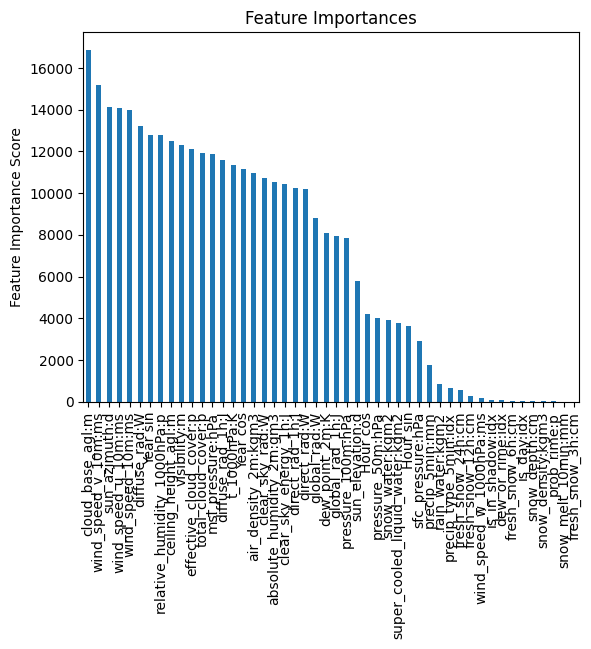

In [59]:
model_c = xgb.XGBRegressor(
 device='cuda',
 learning_rate =0.05,
 n_estimators=2049,
 max_depth=11,
 min_child_weight=6,
 gamma=2.700424640722136,
 subsample=0.7625820679319437,
 colsample_bytree=0.6696305568496206,
 seed=42,
 eval_metric= 'mae',
 booster='gbtree',
 reg_alpha = 146.95411105137276,
 reg_lambda = 125.49465203052867,
)

modelfit(model_c, data.C.train_x, data.C.train_y, data.C.val_x, data.C.val_y, useTrainCV = False)

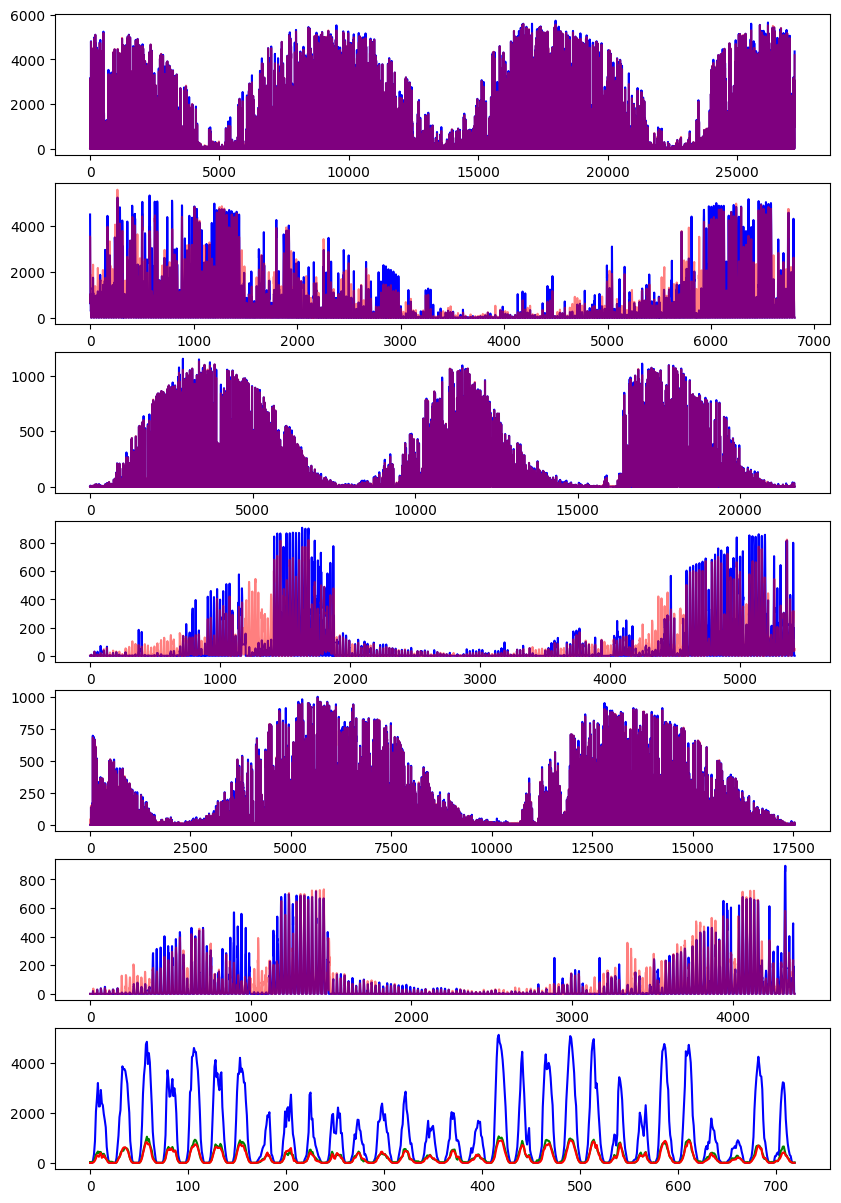

In [68]:
preds_a_train = np.absolute(model_a.predict(train_data_a))
preds_a_val = np.absolute(model_a.predict(val_data_a))
preds_a_test = np.absolute(model_a.predict(test_a))

preds_b_train = np.absolute(model_b.predict(train_data_b))
preds_b_val = np.absolute(model_b.predict(val_data_b))
preds_b_test = np.absolute(model_b.predict(test_b))

preds_c_train = np.absolute(model_c.predict(train_data_c))
preds_c_val = np.absolute(model_c.predict(val_data_c))
preds_c_test = np.absolute(model_c.predict(test_c))

fig, axs = plt.subplots(7, figsize=(10, 15))
axs[0].plot((train_a_y), color="blue")
axs[0].plot(preds_a_train, color="red", alpha=0.5)

axs[1].plot((val_a_y), color="blue")
axs[1].plot(preds_a_val, color="red", alpha=0.5)


axs[2].plot((train_b_y), color="blue")
axs[2].plot(preds_b_train, color="red", alpha=0.5)

axs[3].plot((val_b_y), color="blue")
axs[3].plot(preds_b_val, color="red", alpha=0.5)

axs[4].plot((train_c_y), color="blue")
axs[4].plot(preds_c_train, color="red", alpha=0.5)

axs[5].plot((val_c_y), color="blue")
axs[5].plot(preds_c_val, color="red", alpha=0.5)

axs[6].plot(preds_a_test, color="blue")
axs[6].plot(preds_b_test, color="green")
axs[6].plot(preds_c_test, color="red")


In [64]:
def objective(space):
    
    alg = xgb.XGBRegressor(
     device='cuda',
     learning_rate =0.2,
     n_estimators= 500,
     max_depth= round(space['max_depth']),
     min_child_weight= space['min_child_weight'],
     gamma=space['gamma'],
     subsample= space['subsample'],
     colsample_bytree= space['colsample_bytree'],
     nthread=4,
     seed=42,
     eval_metric= 'mae',
     booster='gbtree',
     reg_lambda=space['reg_lambda'],
     reg_alpha=space['reg_alpha'],
     early_stopping_rounds = 10
    )
        #data.B.train_x, data.B.train_y, data.B.val_x, data.B.val_y
    #Fit the algorithm on the data
    alg.fit(data.B.train_x, data.B.train_y, eval_set=[(data.B.train_x, data.B.train_y),
                                                      (data.B.val_x, data.B.val_y)], verbose=False)
        
    #Predict training set:
    dval_predictions = alg.predict( data.B.val_x)
    
    mae_val = mean_absolute_error(dval_predictions, data.B.val_y)
                    
    return {'loss' : mae_val, 'status' : STATUS_OK}

In [65]:
space={
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,180),
        'reg_lambda' : hp.uniform('reg_lambda', 0,180),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

#{'colsample_bytree': 0.8563576286836063, 'gamma': 2.3530939377340916, 'max_depth': 17.0, 'min_child_weight': 9.0, 'reg_alpha': 5.362099435153887, 'reg_lambda': 64.39374187968356, 'subsample': 0.6745835850987192}

100%|████████████████████████████████████████████| 1000/1000 [18:05<00:00,  1.09s/trial, best loss: 23.045804676665327]
The best hyperparameters are :  

{'colsample_bytree': 0.8615770908405836, 'gamma': 6.9462927163070525, 'max_depth': 10.0, 'min_child_weight': 2.0, 'reg_alpha': 39.56391755892025, 'reg_lambda': 165.13746485969003, 'subsample': 0.5425452253269976}


In [250]:
MAX_EPOCHS = 30

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [251]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [252]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [253]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [254]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=48, bias_initializer=initializers.Constant(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),
    tf.keras.layers.Dense(units=64, bias_initializer=initializers.Constant(0.1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, bias_initializer=initializers.Constant(0.1))
    ),

    tf.keras.layers.Dense(units=1, activation="relu", bias_initializer=initializers.Constant(0.1))

])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [255]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]
#[0.004080631770193577, 0.023939160630106926]

Epoch 1/30
31/31 [==============================] - 28s 288ms/step - loss: 0.0345 - mean_absolute_error: 0.0956 - val_loss: 0.0078 - val_mean_absolute_error: 0.0353
Epoch 2/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0119 - mean_absolute_error: 0.0556 - val_loss: 0.0053 - val_mean_absolute_error: 0.0295
Epoch 3/30
31/31 [==============================] - 6s 179ms/step - loss: 0.0098 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0280
Epoch 4/30
31/31 [==============================] - 6s 181ms/step - loss: 0.0088 - mean_absolute_error: 0.0476 - val_loss: 0.0049 - val_mean_absolute_error: 0.0273
Epoch 5/30
31/31 [==============================] - 6s 200ms/step - loss: 0.0082 - mean_absolute_error: 0.0456 - val_loss: 0.0044 - val_mean_absolute_error: 0.0268
Epoch 6/30
31/31 [==============================] - 6s 206ms/step - loss: 0.0081 - mean_absolute_error: 0.0450 - val_loss: 0.0045 - val_mean_absolute_error: 0.0261
Epoch 7/30
31/3

In [256]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/30
30/30 [==============================] - 33s 407ms/step - loss: 0.0383 - mean_absolute_error: 0.0877 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 2/30
30/30 [==============================] - 6s 187ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 3/30
30/30 [==============================] - 7s 231ms/step - loss: 0.0382 - mean_absolute_error: 0.0864 - val_loss: 0.0296 - val_mean_absolute_error: 0.0589
Epoch 4/30
4/4 [==============================] - 0s 117ms/step - loss: 0.0296 - mean_absolute_error: 0.0589
measure b: [0.02958689071238041, 0.05894533544778824]


In [257]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/30
25/25 [==============================] - 42s 512ms/step - loss: 0.0388 - mean_absolute_error: 0.0907 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 2/30
25/25 [==============================] - 6s 223ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 3/30
25/25 [==============================] - 6s 252ms/step - loss: 0.0358 - mean_absolute_error: 0.0814 - val_loss: 0.0163 - val_mean_absolute_error: 0.0458
Epoch 4/30
4/4 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
measure c: [0.016322463750839233, 0.04580168426036835]


In [258]:
#lstm_model_a.get_weight_paths()

In [259]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 2s 93ms/step


In [260]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:2: RuntimeWarning: invalid value encountered in divide
  pred_b = pred_b.flatten() * b_max / pred_b.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:3: RuntimeWarning: invalid value encountered in divide
  pred_c = pred_c.flatten() * c_max / pred_c.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:6: RuntimeWarning: invalid value encountered in divide
  pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: divide by zero encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:7: RuntimeWarning: invalid value encountered in divide
  pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()
C:\Users\marti\AppData\Local\Temp\ipykernel_7092\1906007758.py:10: RuntimeWarning: divide by zero encountered in divid

In [261]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

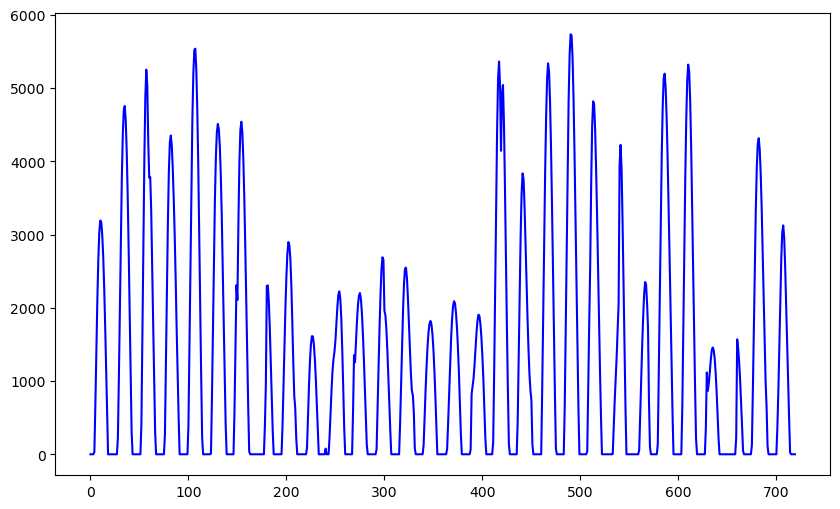

In [262]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

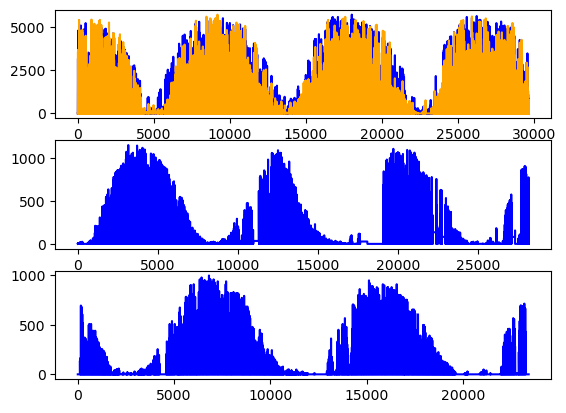

In [263]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

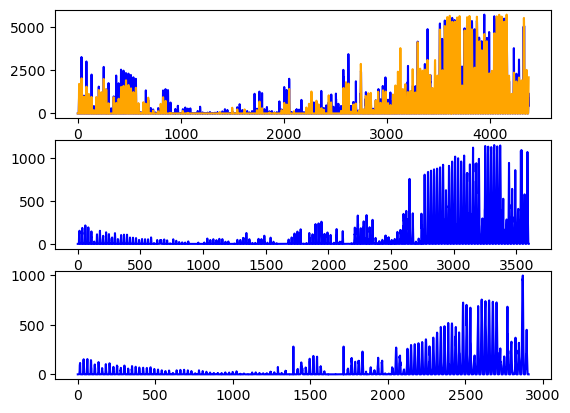

In [264]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [59]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [60]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [61]:
submit = np.concatenate((np.concatenate((preds_a_test, preds_b_test)),preds_c_test))

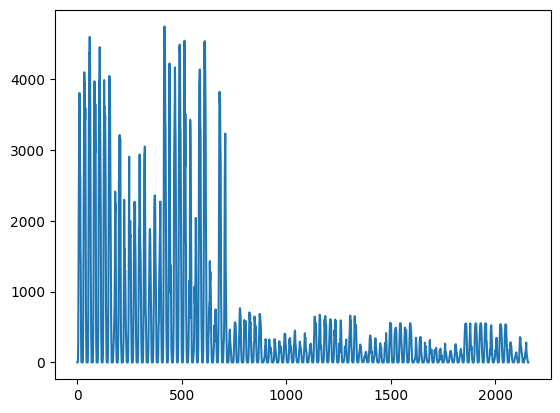

In [62]:
plt.plot(submit)

In [63]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("xgboost_4.csv", index=False)